The following code has been manually translated from Spanish to English. Due to execution times, code subject to dependencies that take a long time to execute, mainly graphics, are still in the original language.

Authors:
- Alcalde Benítez, Patricia Fuxi
- Vulpe, Beatriz Noelia

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pip install pycaret

# **REGRESSION**

In [3]:
songs = pd.read_csv('train_ap1_mcp_23_24_train.csv')

In [4]:
songs

,song_name,song_id,popularity,acousticness,danceability,song_duration_ms,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,I’ll Come Running (To Tie Your Shoe),782579,34,0.5350,0.584,218227,0.459,0.034200,0,0.1530,-14.127,0,0.0319,124.465,3,0.7650
1,Mohican,150969,47,0.3210,0.758,206600,0.503,0.000234,0,0.1210,-11.445,0,0.1600,120.027,3,0.4770
2,"Todo Quedó, Quedó (En Vivo) [feat. Nelsón Arri...",261974,25,0.1680,0.732,304970,0.824,0.000021,11,0.9420,-9.296,0,0.1170,102.002,3,0.8260
3,Be Glorified,360055,39,0.0726,0.553,307040,0.718,0.000003,8,0.1520,-6.385,0,0.0248,87.989,3,0.6770
4,Guilty Pleasure,745239,57,0.0032,0.641,204435,0.844,0.000000,9,0.1060,-5.758,0,0.0465,150.030,3,0.8340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,Make Me Wanna,74370,62,0.0369,0.545,225067,0.818,0.000000,0,0.1010,-6.380,0,0.0541,109.019,2,0.6790
23996,Maui Battles - Score Demo,19552,41,0.2350,0.232,117733,0.587,0.918000,1,0.3950,-13.186,1,0.1010,81.943,3,0.1130
23997,6 Concerts transcrits en sextuor / 6e concert:...,549733,15,0.8900,0.624,248733,0.269,0.879000,8,0.1200,-20.798,1,0.0391,128.212,2,0.3820
23998,"Puccini: La bohème, Act 1: ""O soave fanciulla""...",884432,13,0.9780,0.196,248307,0.134,0.026100,5,0.1180,-13.981,1,0.0365,84.730,3,0.0386


##**0. DATA PREPROCESSING AND CLEANING**



Our dataset has 15 columns: `song_name, song_id, song_duration_ms, acousticness, danceability, energy, instrumentalness, key, liveness, loudness, audio_mode, speechiness, tempo, time_signature y audio_valence`. The goal is to estimate the `popularity` column based on these features.

**Does the duration of a song affect its popularity? Are instrumental songs more popular than non-instrumental ones? Can the tempo of a song affect its success?**

As a first step, we will analyze the nature of the data, check for the presence of missing (null or NaN) or non-representative symbols to decide if any processing is needed.

In [5]:
column_info = pd.DataFrame({'Data Type': songs.dtypes, # data types of each column
    'Distinct Values': songs.nunique(), # number of unique values
    'Null Values': songs.isnull().sum(), # number of null values
    'Missing Values' : songs.isna().sum(), # number of NaN values
})

column_info

,Data Type,Distinct Values,Null Values,Missing Values
song_name,object,21808,0,0
song_id,int64,23721,0,0
popularity,int64,98,0,0
acousticness,float64,3438,0,0
danceability,float64,1035,0,0
song_duration_ms,int64,17279,0,0
energy,float64,1754,0,0
instrumentalness,float64,4472,0,0
key,int64,12,0,0
liveness,float64,1593,0,0


In [6]:
print('Non-representative symbols: ', songs[(songs == '?').any(axis=1)].index.to_list())

Non-representative symbols:  []


We can infer from the data types of the columns that 14 out of 15 do not have non-representative symbols.

In [7]:
print("\nDescriptive statistics of the DataFrame:")
songs.describe()


Descriptive statistics of the DataFrame:


,song_id,popularity,acousticness,danceability,song_duration_ms,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,500840.366625,41.082417,0.370186,0.552322,2.358258e+05,0.569191,0.149253,5.330167,0.214456,-9.596249,0.347625,0.121792,117.645065,2.897083,0.452112
std,288296.975063,18.109720,0.356401,0.186490,1.275362e+05,0.264864,0.303700,3.461212,0.197887,6.038361,0.476226,0.188332,30.925825,0.397699,0.259177
min,18.000000,0.000000,0.000001,0.059000,1.721300e+04,0.000263,0.000000,0.000000,0.015200,-47.499000,0.000000,0.022500,34.856000,0.000000,0.000000
25%,251669.500000,29.000000,0.036700,0.433000,1.830998e+05,0.381000,0.000000,3.000000,0.097000,-11.848250,0.000000,0.036700,92.938000,3.000000,0.235000
50%,500290.000000,43.000000,0.233000,0.570000,2.208930e+05,0.601000,0.000041,5.000000,0.128000,-7.818000,0.000000,0.050000,115.636000,3.000000,0.443000
75%,752274.750000,55.000000,0.728000,0.689000,2.668218e+05,0.787000,0.036500,8.000000,0.264000,-5.500000,1.000000,0.107000,139.162250,3.000000,0.655000
max,999979.000000,99.000000,0.996000,0.980000,5.552917e+06,0.999000,0.993000,11.000000,0.996000,1.342000,1.000000,0.965000,236.735000,4.000000,1.000000


We have a total of 24,000 songs with generally numerical features and no missing values. Certain columns stand out, such as `key, audio_mode, and time_signature`, which have a low number of unique values, suggesting the possibility of treating them as categorical attributes in the training of our models.

Additionally, we are dealing with a non-numerical feature, `song_name`, which we may be interested in later on.

Let's analyze in more detail the specific values within our columns.

In [ ]:
for col in songs.columns:
    print(f"Column: {col}")
    print(songs[col].value_counts())
    print("--------------------")

Column: song_name
Ghost                                                                                           8
Home                                                                                            8
Stay                                                                                            7
Up All Night                                                                                    7
Love                                                                                            7
                                                                                               ..
Time Lapse                                                                                      1
Don't Come Out The House (with 21 Savage)                                                       1
Return to Mother - From "Tangled"/Score                                                         1
Verdi: Rigoletto, Act 3: "La donna è mobile" (Duke of Mantua)                                   1
Pu

Let's visualize the distribution of values for each column in the DataFrame using histograms.

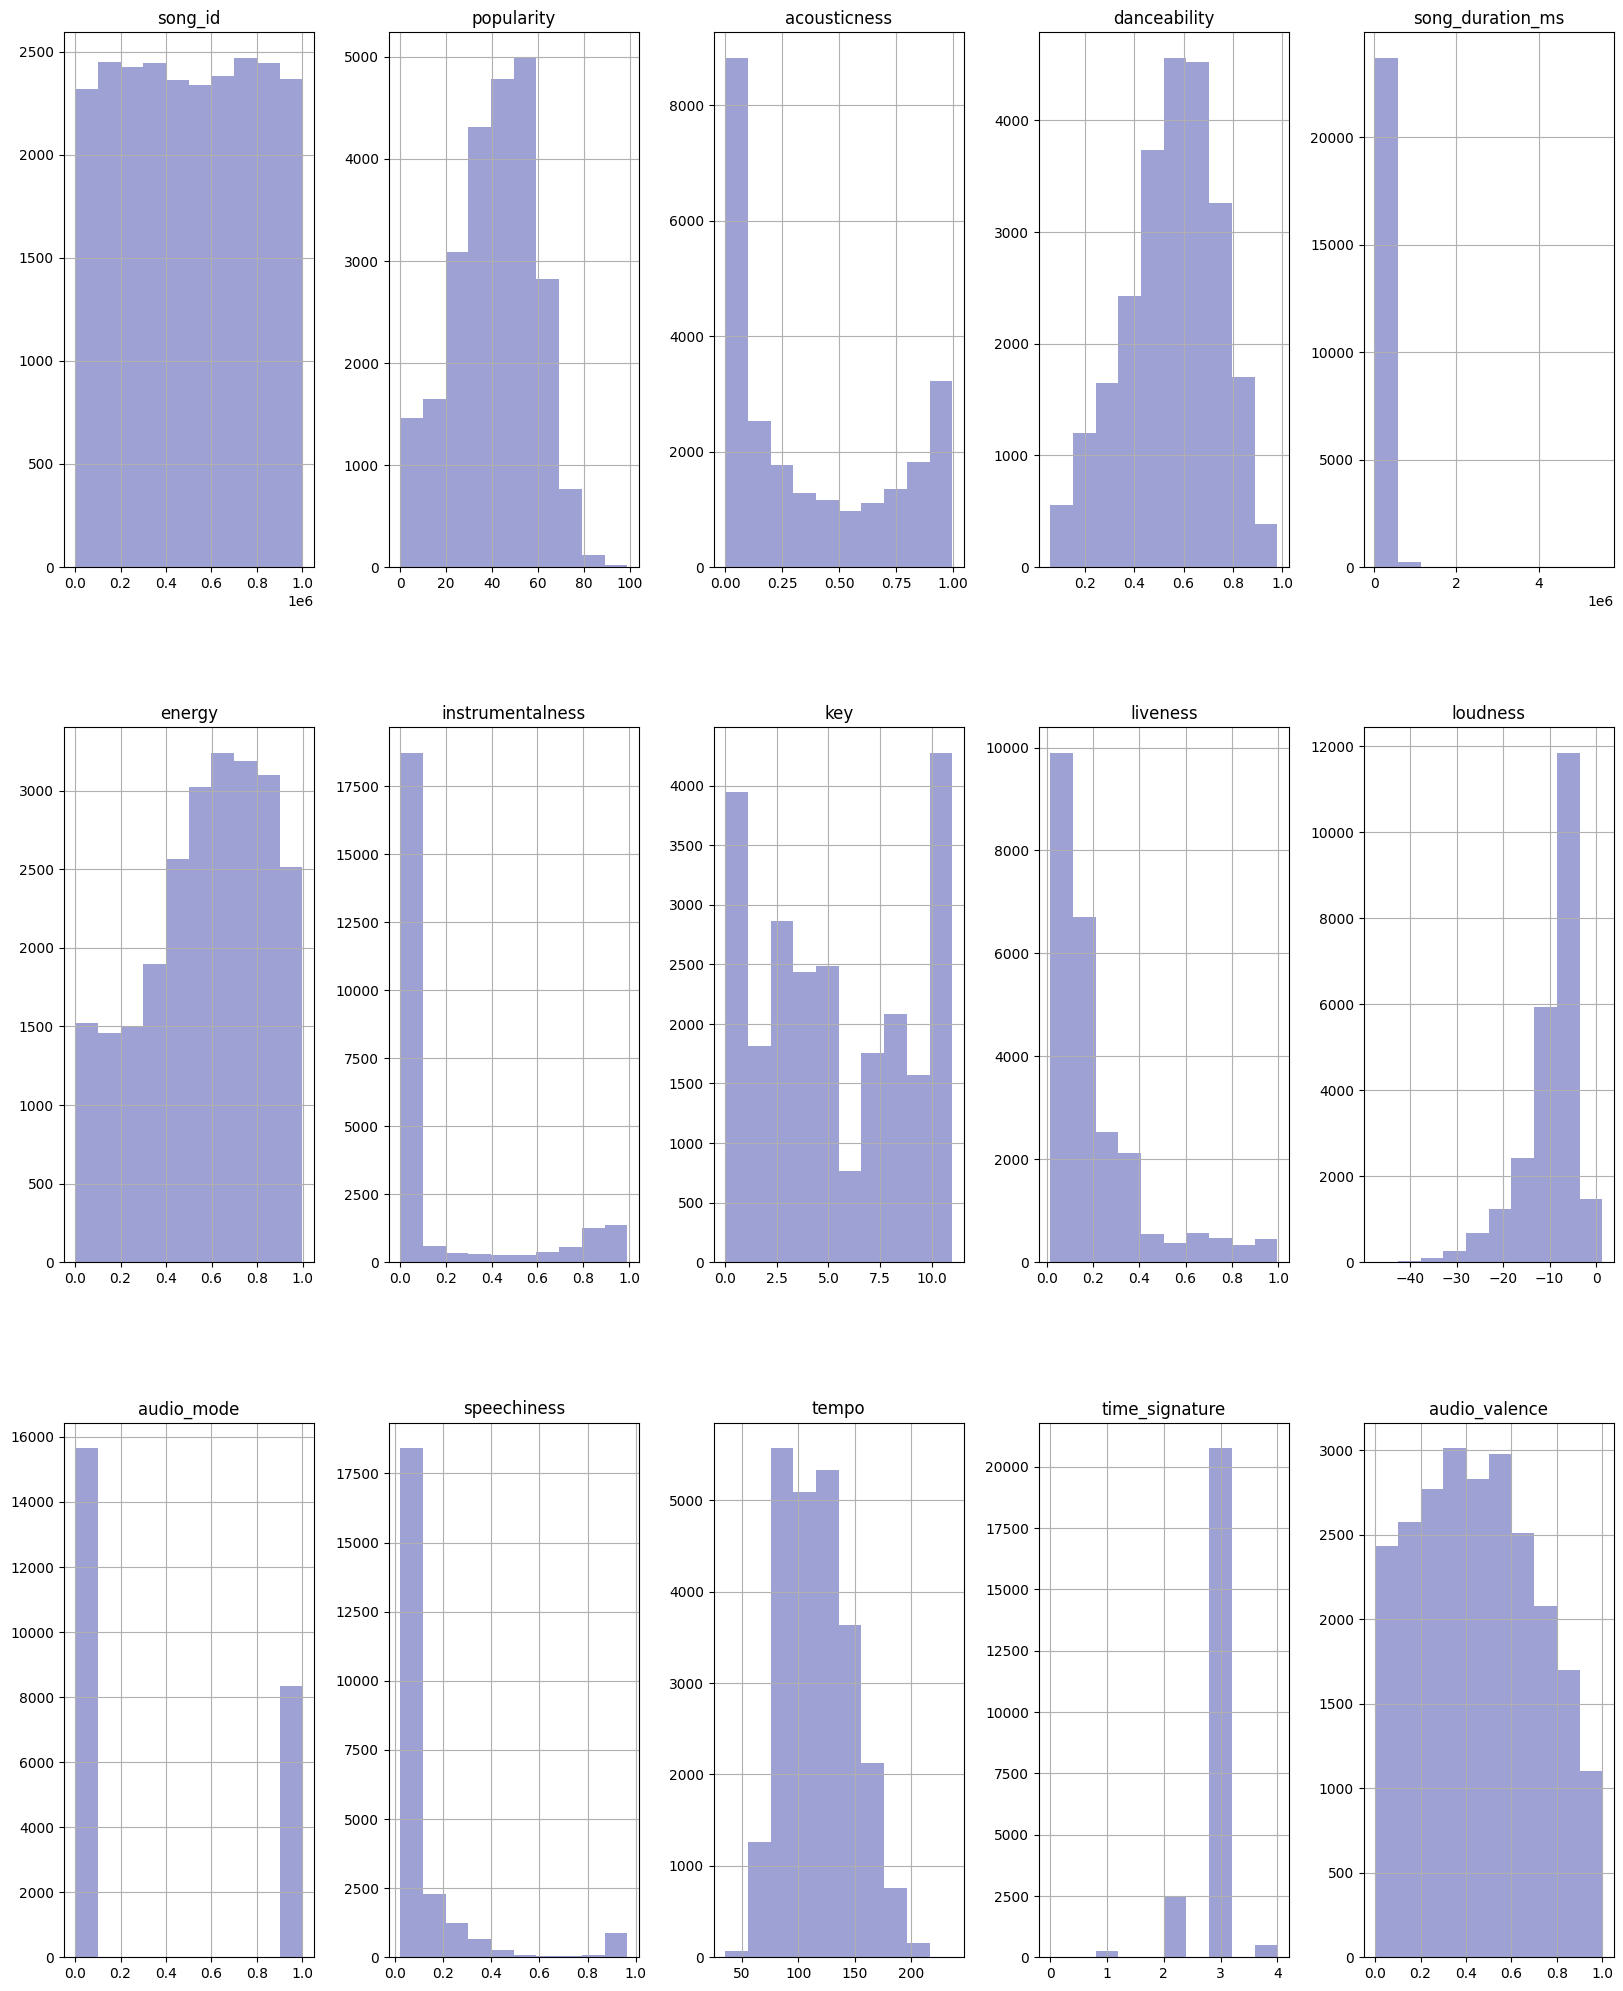

In [ ]:
songs.hist(layout=(3, 5), figsize=(20, 25), color='#9EA1D4')
plt.show()

A couple of things stand out in the value counts of the columns:

- There are **different instances of songs with the same name**, such as "Ghost", "Home", "Love." This could suggest that the song name is an influential decision in the release of a song and might potentially help us improve results in our models.

- On the other hand, we have **duplicate values in the `song_id` column**. We'll need to analyze these samples, as a song_id should reference a unique song.

### **Duplicate values in `song_id`**

In [ ]:
songs[songs['song_id'].duplicated()]

,song_name,song_id,popularity,acousticness,danceability,song_duration_ms,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
1094,Entre deux eaux,290857,0,0.5410,0.474,194026,0.3050,0.000000,3,0.5220,-13.282,0,0.0967,79.448,3,0.621
1586,16 Days,824610,48,0.2850,0.577,234667,0.7050,0.000001,3,0.1070,-6.565,0,0.0538,127.591,3,0.387
1736,Sahel,609989,30,0.8380,0.497,364075,0.2710,0.883000,8,0.0804,-14.980,0,0.0337,153.035,2,0.194
2238,It's Christmas Time Again,110928,50,0.0744,0.530,203029,0.7060,0.000000,2,0.2720,-5.263,0,0.0354,141.948,3,0.790
3170,Mesmerize,823561,68,0.0554,0.762,278720,0.6410,0.000000,4,0.4540,-6.784,0,0.2090,90.089,3,0.368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,Ffunny Ffriends,572408,50,0.2080,0.694,256840,0.8930,0.849000,2,0.0869,-4.673,0,0.0746,90.968,3,0.641
23809,Touch,294106,41,0.7160,0.255,265520,0.4640,0.462000,10,0.1130,-15.797,1,0.0546,144.237,3,0.176
23819,Vacation,360766,67,0.0431,0.739,209142,0.7540,0.000000,11,0.0999,-5.034,0,0.0350,150.017,3,0.793
23857,Inspiration Information,688045,50,0.0143,0.805,252200,0.3800,0.009740,10,0.2280,-16.387,0,0.0571,89.658,3,0.961


We have 279 duplicate rows that need to be removed. However, before addressing these duplications, we need to investigate the cause.

In [ ]:
songs[songs['song_id']== 290857]

,song_name,song_id,popularity,acousticness,danceability,song_duration_ms,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
589,Knew U,290857,51,0.126,0.822,191147,0.742,0.00129,2,0.169,-5.384,0,0.2400,96.384,3,0.709
1094,Entre deux eaux,290857,0,0.541,0.474,194026,0.305,0.00000,3,0.522,-13.282,0,0.0967,79.448,3,0.621


In [ ]:
songs[songs['song_id']== 824610]

,song_name,song_id,popularity,acousticness,danceability,song_duration_ms,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
263,Aurora's Return / Maleficent's Evil Spell,824610,11,0.983,0.199,306600,0.0328,0.888000,1,0.246,-23.256,0,0.0334,90.598,2,0.0637
1586,16 Days,824610,48,0.285,0.577,234667,0.7050,0.000001,3,0.107,-6.565,0,0.0538,127.591,3,0.3870


In [ ]:
songs[songs['song_id']== 609989]

,song_name,song_id,popularity,acousticness,danceability,song_duration_ms,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
1637,Lately,609989,61,0.0335,0.620,243080,0.812,0.000,3,0.1320,-5.843,0,0.0436,92.024,3,0.573
1736,Sahel,609989,30,0.8380,0.497,364075,0.271,0.883,8,0.0804,-14.980,0,0.0337,153.035,2,0.194


We can see that there are different songs with the same ID. We can eliminate this column since initially, we intended to use it as an index.

In [8]:
songs = songs.drop('song_id', axis=1)

### **Initial treatment of `song_name`**

In [9]:
names = list(songs['song_name'].value_counts()[songs['song_name'].value_counts() >= 5].index)

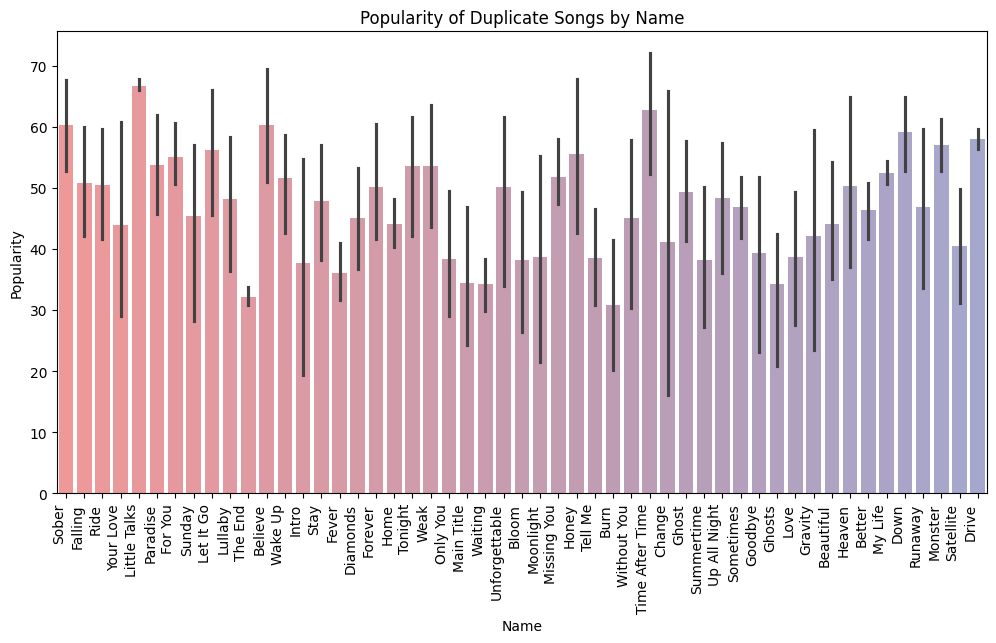

In [12]:
# We will visualize the popularity of duplicate songs by name.
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='song_name', y='popularity', data=songs[songs['song_name'].isin(names)], palette=("blend:#FD8A8A,#9EA1D4"))
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, ha='right')  # Rotation on x-axis labels for better readability.
plt.title('Popularity of Duplicate Songs by Name')
plt.xlabel('Name')
plt.ylabel('Popularity')
plt.show()

All the songs that have titles within the list of most repeated names (>= 5) have a popularity in the range of 30-70. It's true that within songs with the same name, there is high variability in popularity, but we consider that the name could have an influence.

In our case, we could also consider that perhaps the length of the title could influence the popularity of the song. Therefore, we will create another column called `title_length` with the length of each title.

In [13]:
songs['title_length'] = songs['song_name'].apply(lambda x: len(x))

In [14]:
songs

,song_name,popularity,acousticness,danceability,song_duration_ms,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,title_length
0,I’ll Come Running (To Tie Your Shoe),34,0.5350,0.584,218227,0.459,0.034200,0,0.1530,-14.127,0,0.0319,124.465,3,0.7650,36
1,Mohican,47,0.3210,0.758,206600,0.503,0.000234,0,0.1210,-11.445,0,0.1600,120.027,3,0.4770,7
2,"Todo Quedó, Quedó (En Vivo) [feat. Nelsón Arri...",25,0.1680,0.732,304970,0.824,0.000021,11,0.9420,-9.296,0,0.1170,102.002,3,0.8260,50
3,Be Glorified,39,0.0726,0.553,307040,0.718,0.000003,8,0.1520,-6.385,0,0.0248,87.989,3,0.6770,12
4,Guilty Pleasure,57,0.0032,0.641,204435,0.844,0.000000,9,0.1060,-5.758,0,0.0465,150.030,3,0.8340,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,Make Me Wanna,62,0.0369,0.545,225067,0.818,0.000000,0,0.1010,-6.380,0,0.0541,109.019,2,0.6790,13
23996,Maui Battles - Score Demo,41,0.2350,0.232,117733,0.587,0.918000,1,0.3950,-13.186,1,0.1010,81.943,3,0.1130,25
23997,6 Concerts transcrits en sextuor / 6e concert:...,15,0.8900,0.624,248733,0.269,0.879000,8,0.1200,-20.798,1,0.0391,128.212,2,0.3820,58
23998,"Puccini: La bohème, Act 1: ""O soave fanciulla""...",13,0.9780,0.196,248307,0.134,0.026100,5,0.1180,-13.981,1,0.0365,84.730,3,0.0386,92


### **Treatment for training**

First, we obtain X and y.

In [ ]:
X = songs.drop(['popularity'], axis=1)
y = songs['popularity']

**One-hot encoding of the columns we have considered categorical:**

Earlier, we deemed appropriate to treat the columns `key, audio_mode, and time_signature` as categorical.

In [ ]:
X = pd.get_dummies(X, columns=['key', 'audio_mode', 'time_signature'])
X

,song_name,acousticness,danceability,song_duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_9,key_10,key_11,audio_mode_0,audio_mode_1,time_signature_0,time_signature_1,time_signature_2,time_signature_3,time_signature_4
0,I’ll Come Running (To Tie Your Shoe),0.5350,0.584,218227,0.459,0.034200,0.1530,-14.127,0.0319,124.465,...,0,0,0,1,0,0,0,0,1,0
1,Mohican,0.3210,0.758,206600,0.503,0.000234,0.1210,-11.445,0.1600,120.027,...,0,0,0,1,0,0,0,0,1,0
2,"Todo Quedó, Quedó (En Vivo) [feat. Nelsón Arri...",0.1680,0.732,304970,0.824,0.000021,0.9420,-9.296,0.1170,102.002,...,0,0,1,1,0,0,0,0,1,0
3,Be Glorified,0.0726,0.553,307040,0.718,0.000003,0.1520,-6.385,0.0248,87.989,...,0,0,0,1,0,0,0,0,1,0
4,Guilty Pleasure,0.0032,0.641,204435,0.844,0.000000,0.1060,-5.758,0.0465,150.030,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,Make Me Wanna,0.0369,0.545,225067,0.818,0.000000,0.1010,-6.380,0.0541,109.019,...,0,0,0,1,0,0,0,1,0,0
23996,Maui Battles - Score Demo,0.2350,0.232,117733,0.587,0.918000,0.3950,-13.186,0.1010,81.943,...,0,0,0,0,1,0,0,0,1,0
23997,6 Concerts transcrits en sextuor / 6e concert:...,0.8900,0.624,248733,0.269,0.879000,0.1200,-20.798,0.0391,128.212,...,0,0,0,0,1,0,0,1,0,0
23998,"Puccini: La bohème, Act 1: ""O soave fanciulla""...",0.9780,0.196,248307,0.134,0.026100,0.1180,-13.981,0.0365,84.730,...,0,0,0,0,1,0,0,0,1,0


**Word embedding of `song_name`:**

The presence of a specific word in the title of a song could influence its popularity.

In [ ]:
!python -m spacy download en_core_web_md

2023-12-22 19:35:03.841573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 19:35:03.841704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 19:35:03.844396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 19:35:03.858933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 19:35:07.205869: W tensorflow/compiler/tf2

In [ ]:
import re

def limpiar_texto(texto):
    # Removing accents
    texto = re.sub(r'[áéíóúÁÉÍÓÚ]', lambda x: 'aeiouAEIOU'[('áéíóúÁÉÍÓÚ'.index(x.group()) // 5)], texto)

    # removing parentheses, punctuation marks, numbers, and symbols.
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)

    # convertion to lowercase.
    texto = texto.lower()

    return texto

# cleaning function to the 'song_name' column.
X['song_name'] = X['song_name'].apply(limpiar_texto)

In [ ]:
X['song_name']

0                        ill come running to tie your shoe
1                                                  mohican
2             todo queda queda en vivo feat nelsan arrieta
3                                             be glorified
4                                          guilty pleasure
                               ...                        
23995                                        make me wanna
23996                             maui battles  score demo
23997     concerts transcrits en sextuor  e concert  la...
23998    puccini la bohme act  o soave fanciulla schaun...
23999                                      flava in ya ear
Name: song_name, Length: 24000, dtype: object

In [ ]:
import spacy

# We vectorizatize our text using the spaCy model and swifter to improve execution time.
nlp = spacy.load('en_core_web_md')

word2vec = X['song_name'].astype(str).apply(lambda x: nlp(x).vector)

In [ ]:
word2vec

0        [-0.60543287, 5.7348857, -4.4376287, -1.787697...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [1.346525, -0.97045124, -2.7105126, -0.2793424...
3        [-5.72735, 1.6315801, -2.54475, 3.93855, -3.52...
4        [-1.35015, -1.7755, -4.1960497, -2.3644001, 0....
                               ...                        
23995    [-0.16060002, 3.7935665, -3.7689, -3.5189667, ...
23996    [-0.82838, -0.24565999, 0.347022, -0.18219398,...
23997    [1.3491573, -0.6208208, -0.6359454, -0.0897791...
23998    [-0.28695077, -0.029866843, -0.6050635, -0.973...
23999    [0.770175, 2.62679, -1.6134748, 1.9795926, -0....
Name: song_name, Length: 24000, dtype: object

In [ ]:
# DataFrame from the lists in 'word2vec'.
df = pd.DataFrame(word2vec.tolist(), columns=[f'feature_{i+1}' for i in range(300)])

# Concatenate the new DataFrame with 'songs'.
songs_with_word2vec = pd.concat([X, df], axis=1)

In [ ]:
songs_with_word2vec

,song_name,acousticness,danceability,song_duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300
0,ill come running to tie your shoe,0.5350,0.584,218227,0.459,0.034200,0.1530,-14.127,0.0319,124.465,...,-0.546770,-0.612664,-2.165328,1.191589,-1.118543,-0.853929,-1.151014,1.335257,-2.434390,1.630590
1,mohican,0.3210,0.758,206600,0.503,0.000234,0.1210,-11.445,0.1600,120.027,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,todo queda queda en vivo feat nelsan arrieta,0.1680,0.732,304970,0.824,0.000021,0.9420,-9.296,0.1170,102.002,...,-1.280375,0.826925,0.725751,2.739488,0.843881,1.432671,2.509310,1.392562,0.489144,-2.588342
3,be glorified,0.0726,0.553,307040,0.718,0.000003,0.1520,-6.385,0.0248,87.989,...,6.860230,-5.187655,1.331735,5.556200,-2.066630,3.859220,0.673415,-2.809930,-1.797130,5.860775
4,guilty pleasure,0.0032,0.641,204435,0.844,0.000000,0.1060,-5.758,0.0465,150.030,...,2.958450,-1.824450,0.893805,-2.049950,-2.752290,1.341395,1.331860,0.438935,-2.009055,1.349455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,make me wanna,0.0369,0.545,225067,0.818,0.000000,0.1010,-6.380,0.0541,109.019,...,3.603800,-1.168983,0.716337,-3.953523,-0.975333,-3.693400,-1.799300,4.632983,-3.231289,-2.364753
23996,maui battles score demo,0.2350,0.232,117733,0.587,0.918000,0.3950,-13.186,0.1010,81.943,...,1.139340,-0.585328,0.189314,2.880100,-0.019120,0.915648,-1.351842,-0.019073,-0.136800,0.207600
23997,concerts transcrits en sextuor e concert la...,0.8900,0.624,248733,0.269,0.879000,0.1200,-20.798,0.0391,128.212,...,1.157159,0.094418,0.743943,-1.235949,0.442879,0.809408,3.460483,2.047884,0.284045,-2.331914
23998,puccini la bohme act o soave fanciulla schaun...,0.9780,0.196,248307,0.134,0.026100,0.1180,-13.981,0.0365,84.730,...,0.567508,1.121474,2.029011,-0.282154,0.331595,0.598709,2.085279,0.513525,-0.808246,-0.674935


Now we can remove the `song_name` column.

In [ ]:
X = songs_with_word2vec.drop('song_name', axis=1)

In [ ]:
X.head()

,acousticness,danceability,song_duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300
0,0.5350,0.584,218227,0.459,0.034200,0.153,-14.127,0.0319,124.465,0.765,...,-0.546770,-0.612664,-2.165328,1.191589,-1.118543,-0.853929,-1.151014,1.335257,-2.434390,1.630590
1,0.3210,0.758,206600,0.503,0.000234,0.121,-11.445,0.1600,120.027,0.477,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.1680,0.732,304970,0.824,0.000021,0.942,-9.296,0.1170,102.002,0.826,...,-1.280375,0.826925,0.725751,2.739488,0.843881,1.432671,2.509310,1.392562,0.489144,-2.588342
3,0.0726,0.553,307040,0.718,0.000003,0.152,-6.385,0.0248,87.989,0.677,...,6.860230,-5.187655,1.331735,5.556200,-2.066630,3.859220,0.673415,-2.809930,-1.797130,5.860775
4,0.0032,0.641,204435,0.844,0.000000,0.106,-5.758,0.0465,150.030,0.834,...,2.958450,-1.824450,0.893805,-2.049950,-2.752290,1.341395,1.331860,0.438935,-2.009055,1.349455


In [ ]:
y

0        34
1        47
2        25
3        39
4        57
         ..
23995    62
23996    41
23997    15
23998    13
23999    53
Name: popularity, Length: 24000, dtype: int64



---



As we don't have actual values for the test set, what we will do is reserve a percentage of the training set to evaluate the model through cross-validation.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

## **1. BASELINE TRAINING**

Before training and evaluating our models, we will use the `pycaret` library, which tests a large number of models in a short time to identify additional models.
```
from pycaret.regression import *
model_reg = setup(data = X, target = y, session_id=42)
```




After comparing the available models with `compare_models()`, we consider testing some of the models with the lowest MAE:

 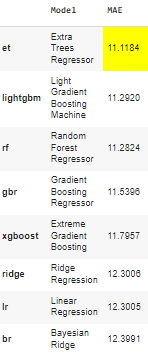

Next, we will train a total of 8 models:
- SGD Regressor, Random Forest, SVM Regressor, and MLP Regressor
- 4 with the lowest error according to `pycaret`: Extra Trees Regressor, Light Gradient Boosting Machine, Gradient Boosting Regressor, and Extreme Gradient Boosting

After training and evaluating various metrics (`cross_val_score` with `'neg_mean_squared_error'`, `R2, MSE, and MAE`), we will proceed with the training of the best models, aiming to enhance their performance by applying **dimensionality reduction** and **feature selection** techniques.

### **1.1 SGD REGRESSOR**

We create lists to store the results obtained with each model for later visualization and comparison.

In [ ]:
errors = []
scores = []
mae_scores = []

We perform a search for the best parameters using `GridSearchCV`.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

hyper_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'learning_rate': ['invscaling', 'adaptive', 'optimal', 'constant']}

np.random.seed(42)

grid_sgd = GridSearchCV(SGDRegressor(), hyper_params, cv=5)
grid_sgd.fit(X_train, y_train)

grid_sgd.best_params_

{'alpha': 0.1, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'}

We will proceed with training using the found parameters and, additionally, apply `StandardScaler` to standardize the features.

This standardization will be present in most of our trainings. This way, algorithms that are sensitive to differences in the magnitude of features will not be affected.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor

# Creamos el modelo
sgd = make_pipeline(StandardScaler(),
                    SGDRegressor(alpha= 0.1,
                                 penalty='elasticnet',
                                 learning_rate='adaptive',
                                 random_state=0))
sgd.fit(X_train, y_train)
y_preds = sgd.predict(X_val)

cv_score = cross_val_score(sgd, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score = sgd.score(X_val, y_val)
mse = mean_squared_error(y_val, y_preds)
mae = mean_absolute_error(y_val, y_preds)

print(f'cv_score: {cv_score.mean()} ')
print(f'R2 Error: {score * 100} %')
print(f'Error MSE: {mse}')
print(f'Error MAE: {mae}')

errors.append(cv_score.mean())
scores.append(score)
mae_scores.append(mae)

cv_score: -237.6030526727619 
R2 Error: 24.524517409863 %
Error MSE: 246.96279707550474
Error MAE: 12.505259394645595


### **1.2 RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

During the process, we have executed the following cells. The first one involves searching for optimal hyperparameters using `GridSearchCV`. Since this process has been very slow and time-consuming, we have saved the results in a variable. This way, every time we need to run the code to obtain the hyperparameters from this file, we don't have to execute this code again.

```
hyper_params = {'n_estimators': [100, 200],
                'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']}

np.random.seed(42)

grid_tree = GridSearchCV(RandomForestRegressor(n_jobs=-1), hyper_params, cv=5)
grid_tree.fit(X_train, y_train)

grid_tree.best_params_
```

We train the model according to the hyperparameters we have found:

In [ ]:
tree = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_estimators= 200,
                                 criterion='squared_error',
                                 n_jobs=-1,
                                 random_state=0))
tree.fit(X_train, y_train)
y_preds = tree.predict(X_val)

cv_score = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score = tree.score(X_val, y_val)
mse = mean_squared_error(y_val, y_preds)
mae = mean_absolute_error(y_val, y_preds)

print(f'cv_score: {cv_score.mean()}')
print(f'R2 Error: {score * 100} %')
print(f'Error MSE: {mse}')
print(f'Error MAE: {mae}')

errors.append(cv_score.mean())
scores.append(score)
mae_scores.append(mae)

cv_score: -204.62183520075087
R2 Error: 36.812042449014314 %
Error MSE: 206.75687259956558
Error MAE: 11.194867342509921


### **1.3 SVM REGRESSOR**

The next model we are going to consider is Support Vector Machines for regression. Similar to Random Forest, the process of searching for the best hyperparameters has been quite lengthy, so we are repeating the procedure.

In [ ]:
from sklearn.svm import SVR

```
hyper_params = {'kernel': ['linear', 'poly', 'sigmoid'],
                'degree': [3, 4, 5],
                'gamma': ['scale', 'auto'],
                'C': [1.0, 10.0]}

np.random.seed(42)

grid_svm = GridSearchCV(SVR(), hyper_params, cv=5)
grid_svm.fit(X_train, y_train)

grid_svm.best_params_
```

We train the model according to the hyperparameters we have found:

In [ ]:
np.random.seed(0)

svr = make_pipeline(StandardScaler(),
                    SVR(kernel='poly',
                        gamma='auto',
                        C=10.0))
svr.fit(X_train, y_train)
y_preds = svr.predict(X_val)

cv_score = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score = svr.score(X_val, y_val)
mse = mean_squared_error(y_val, y_preds)
mae = mean_absolute_error(y_val, y_preds)

print(f'cv_score: {cv_score.mean()}')
print(f'R2 Error: {score * 100} %')
print(f'Error MSE: {mse}')
print(f'Error MAE: {mae}')

errors.append(cv_score.mean())
scores.append(score)
mae_scores.append(mae)

cv_score: -289.69933834810615
R2 Error: 8.571089427797263 %
Error MSE: 299.16389685235384
Error MAE: 13.337021268820852


### **1.4 MLP REGRESSOR**

Finally, we will train a Multi-Layer Perceptron, and we will follow the same process as in the previous cases.

In [ ]:
from sklearn.neural_network import MLPRegressor

```
hyper_params = {'solver': ['adam', 'sgd'],
                'activation': ['relu', 'logistic', 'identity', 'tanh'],
                'learning_rate': ['constant', 'invscaling', 'adaptive']}

np.random.seed(42)

grid_mlp = GridSearchCV(MLPRegressor(max_iter=3000,
                                     hidden_layer_sizes=200), hyper_params, cv=5)
grid_mlp.fit(X_train, y_train)

grid_mlp.best_params_
```

In [ ]:
mlp = make_pipeline(StandardScaler(),
                    MLPRegressor(hidden_layer_sizes=200,
                                 solver='sgd',
                                 activation='logistic',
                                 learning_rate='adaptive',
                                 max_iter=3000,
                                 random_state=0))
mlp.fit(X_train, y_train)
y_preds = mlp.predict(X_val)

cv_score = cross_val_score(mlp, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score = mlp.score(X_val, y_val)
mse = mean_squared_error(y_val, y_preds)
mae = mean_absolute_error(y_val, y_preds)

print(f'cv_score: {cv_score.mean()}')
print(f'R2 Error: {score * 100} %')
print(f'Error MSE: {mse}')
print(f'Error MAE: {mae}')

errors.append(cv_score.mean())
scores.append(score)
mae_scores.append(mae)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


cv_score: -410.113746114068
R2 Error: -40.354096988105994 %
Error MSE: 459.25165608307
Error MAE: 16.447451058608678


### **1.5 GRÁFICAS**

We visualize the results in bar charts.

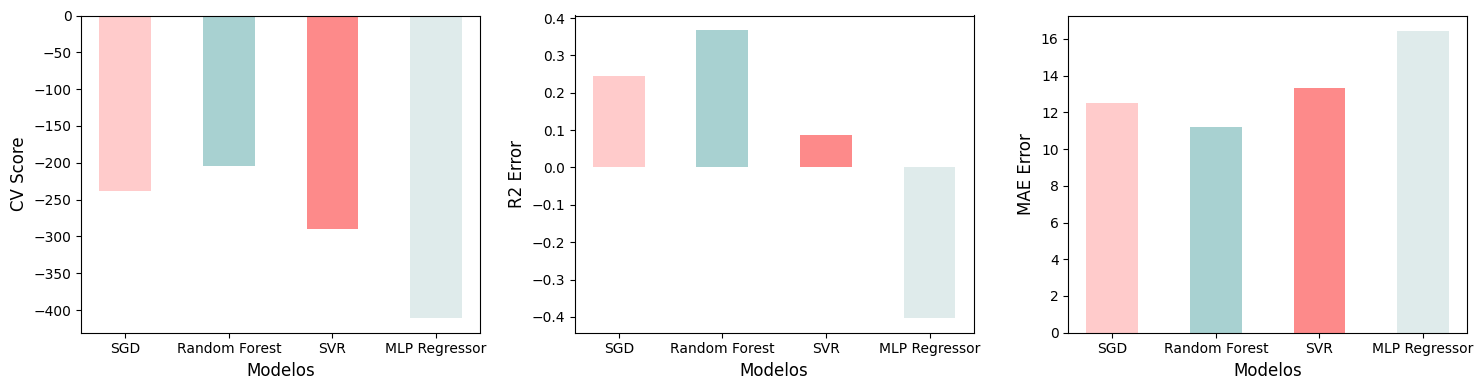

In [ ]:
colors = ['#FFCBCB', '#A8D1D1', '#FD8A8A', '#DFEBEB']

fig, axs = plt.subplots(1, 3, figsize=(15,4))

axs[0].bar(['SGD', 'Random Forest', 'SVR', 'MLP Regressor'],
           errors, width=0.5, color=colors)
axs[0].set_xlabel('Modelos', fontdict={'fontsize': 12})
axs[0].set_ylabel('CV Score', fontdict={'fontsize': 12})

axs[1].bar(['SGD', 'Random Forest', 'SVR', 'MLP Regressor'],
           scores, width=0.5, color=colors)
axs[1].set_xlabel('Modelos', fontdict={'fontsize': 12})
axs[1].set_ylabel('R2 Error', fontdict={'fontsize': 12})

# mae_scores.append(mae)
axs[2].bar(['SGD', 'Random Forest', 'SVR', 'MLP Regressor'],
           mae_scores, width=0.5, color=colors)
axs[2].set_xlabel('Modelos', fontdict={'fontsize': 12})
axs[2].set_ylabel('MAE Error', fontdict={'fontsize': 12})

plt.tight_layout()
plt.show()

### **1.6  MODELS RECOMMENDED BY PYCARET**

In [ ]:
errors_pc = []
scores_pc = []
mae_scores_pc = []

In these cases, given the relatively low execution time compared to the previous models, the parameter search has been done manually.

**EXTRA TREES REGRESSOR**

Mainly, tests have been conducted by varying the following parameters: `n_estimators, max_depth, and min_samples_split`.

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Extra Trees Model with Adjustable Parameters
n_estimators = 400
max_depth = None
min_samples_split = 2

et_model = make_pipeline(StandardScaler(),
                         ExtraTreesRegressor(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_split=min_samples_split,
                                            n_jobs=-1,
                                            random_state=0))

et_model.fit(X_train, y_train)
y_preds_et = et_model.predict(X_val)

# Evaluation Metrics
cv_score_et = cross_val_score(et_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score_et = et_model.score(X_val, y_val)
mse_et = mean_squared_error(y_val, y_preds_et)
mae_et = mean_absolute_error(y_val, y_preds_et)

# Results
print(f'Model: Extra Trees')
print(f'cv_score: {cv_score_et.mean()}')
print(f'R2 Score: {score_et * 100} %')
print(f'MSE: {mse_et}')
print(f'MAE: {mae_et}')

Model: Extra Trees
cv_score: -202.46934349302845
R2 Score: 37.85562602060472 %
MSE: 203.34217011635562
MAE: 11.001233940972224


In [ ]:
errors_pc.append(cv_score_et.mean())
scores_pc.append(score_et)
mae_scores_pc.append(mae_et)

**LGBM REGRESSOR**

Mainly, tests have been conducted by varying the following parameters: `n_estimators, learning_rate, max_depth = -1, and min_child_samples`.


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# LightGBM Model with Adjustable Parameters
n_estimators = 500
learning_rate = 0.1
max_depth = -1  #(-1 means no limit)
min_child_samples = 20

lgbm_model = LGBMRegressor(n_estimators=n_estimators,
                           learning_rate=learning_rate,
                           max_depth=max_depth,
                           min_child_samples=min_child_samples,
                           random_state=0, force_col_wise= True)

lgbm_model = make_pipeline(StandardScaler(), lgbm_model)

lgbm_model.fit(X_train, y_train)
y_preds_lgbm = lgbm_model.predict(X_val)

# Evaluation Metrics
cv_score_lgbm = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score_lgbm = lgbm_model.score(X_val, y_val)
mse_lgbm = mean_squared_error(y_val, y_preds_lgbm)
mae_lgbm = mean_absolute_error(y_val, y_preds_lgbm)

# Results
errors_pc.append(cv_score_lgbm.mean())
scores_pc.append(score_lgbm)
mae_scores_pc.append(mae_lgbm)


print(f'Model: LGBM')
print(f'cv_score: {cv_score_lgbm.mean()}')
print(f'R2 Score: {score_lgbm * 100} %')
print(f'MSE: {mse_lgbm}')
print(f'MAE: {mae_lgbm}')


[LightGBM] [Info] Total Bins 79224
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 329
[LightGBM] [Info] Start training from score 41.167708
[LightGBM] [Info] Total Bins 79219
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 329
[LightGBM] [Info] Start training from score 41.192969
[LightGBM] [Info] Total Bins 79220
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 329
[LightGBM] [Info] Start training from score 41.149544
[LightGBM] [Info] Total Bins 79217
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 329
[LightGBM] [Info] Start training from score 41.205990
[LightGBM] [Info] Total Bins 79220
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 329
[LightGBM] [Info] Start training from score 41.082682
[LightGBM] [Info] Total Bins 79219
[LightGBM] [Info] Number of data points in the tra

**GRADIENT BOOSTING REGRESSOR**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Gradient Boosting model
gb_model = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, random_state=0))
gb_model.fit(X_train, y_train)
y_preds_gb = gb_model.predict(X_val)

# Evaluation Metrics
cv_score_gb = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score_gb = gb_model.score(X_val, y_val)
mse_gb = mean_squared_error(y_val, y_preds_gb)
mae_gb = mean_absolute_error(y_val, y_preds_gb)

# Results
errors_pc.append(cv_score_gb.mean())
scores_pc.append(score_gb)
mae_scores_pc.append(mae_gb)


print(f'Model: Gradient Boosting')
print(f'cv_score: {cv_score_gb.mean()}')
print(f'R2 Score: {score_gb * 100} %')
print(f'MSE: {mse_gb}')
print(f'MAE: {mae_gb}')

Model: Gradient Boosting
cv_score: -212.05165471209642
R2 Score: 34.21228518957605 %
MSE: 215.2635200892515
MAE: 11.599396569926826


**XGB REGRESOR**

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

# XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=0)
xgb_model.fit(X_train, y_train)
y_preds_xgb = xgb_model.predict(X_val)

# Evaluation Metrics
cv_score_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score_xgb = xgb_model.score(X_val, y_val)
mse_xgb = mean_squared_error(y_val, y_preds_xgb)
mae_xgb = mean_absolute_error(y_val, y_preds_xgb)

# Results
errors_pc.append(cv_score_xgb.mean())
scores_pc.append(score_xgb)
mae_scores_pc.append(mae_xgb)

print(f'Model: XGBoost')
print(f'cv_score: {cv_score_xgb.mean()}')
print(f'R2 Score: {score_xgb * 100} %')
print(f'MSE: {mse_xgb}')
print(f'MAE: {mae_xgb}')

Model: XGBoost
cv_score: -226.17030968817153
R2 Score: 30.418226024328575 %
MSE: 227.67803446616142
MAE: 11.789893539007753


Given that these last two models did not show a considerable reduction in error compared to Random Forest and the first two (ExtraTrees and LGBM), exhaustive tests were not conducted.



---



**Plots**

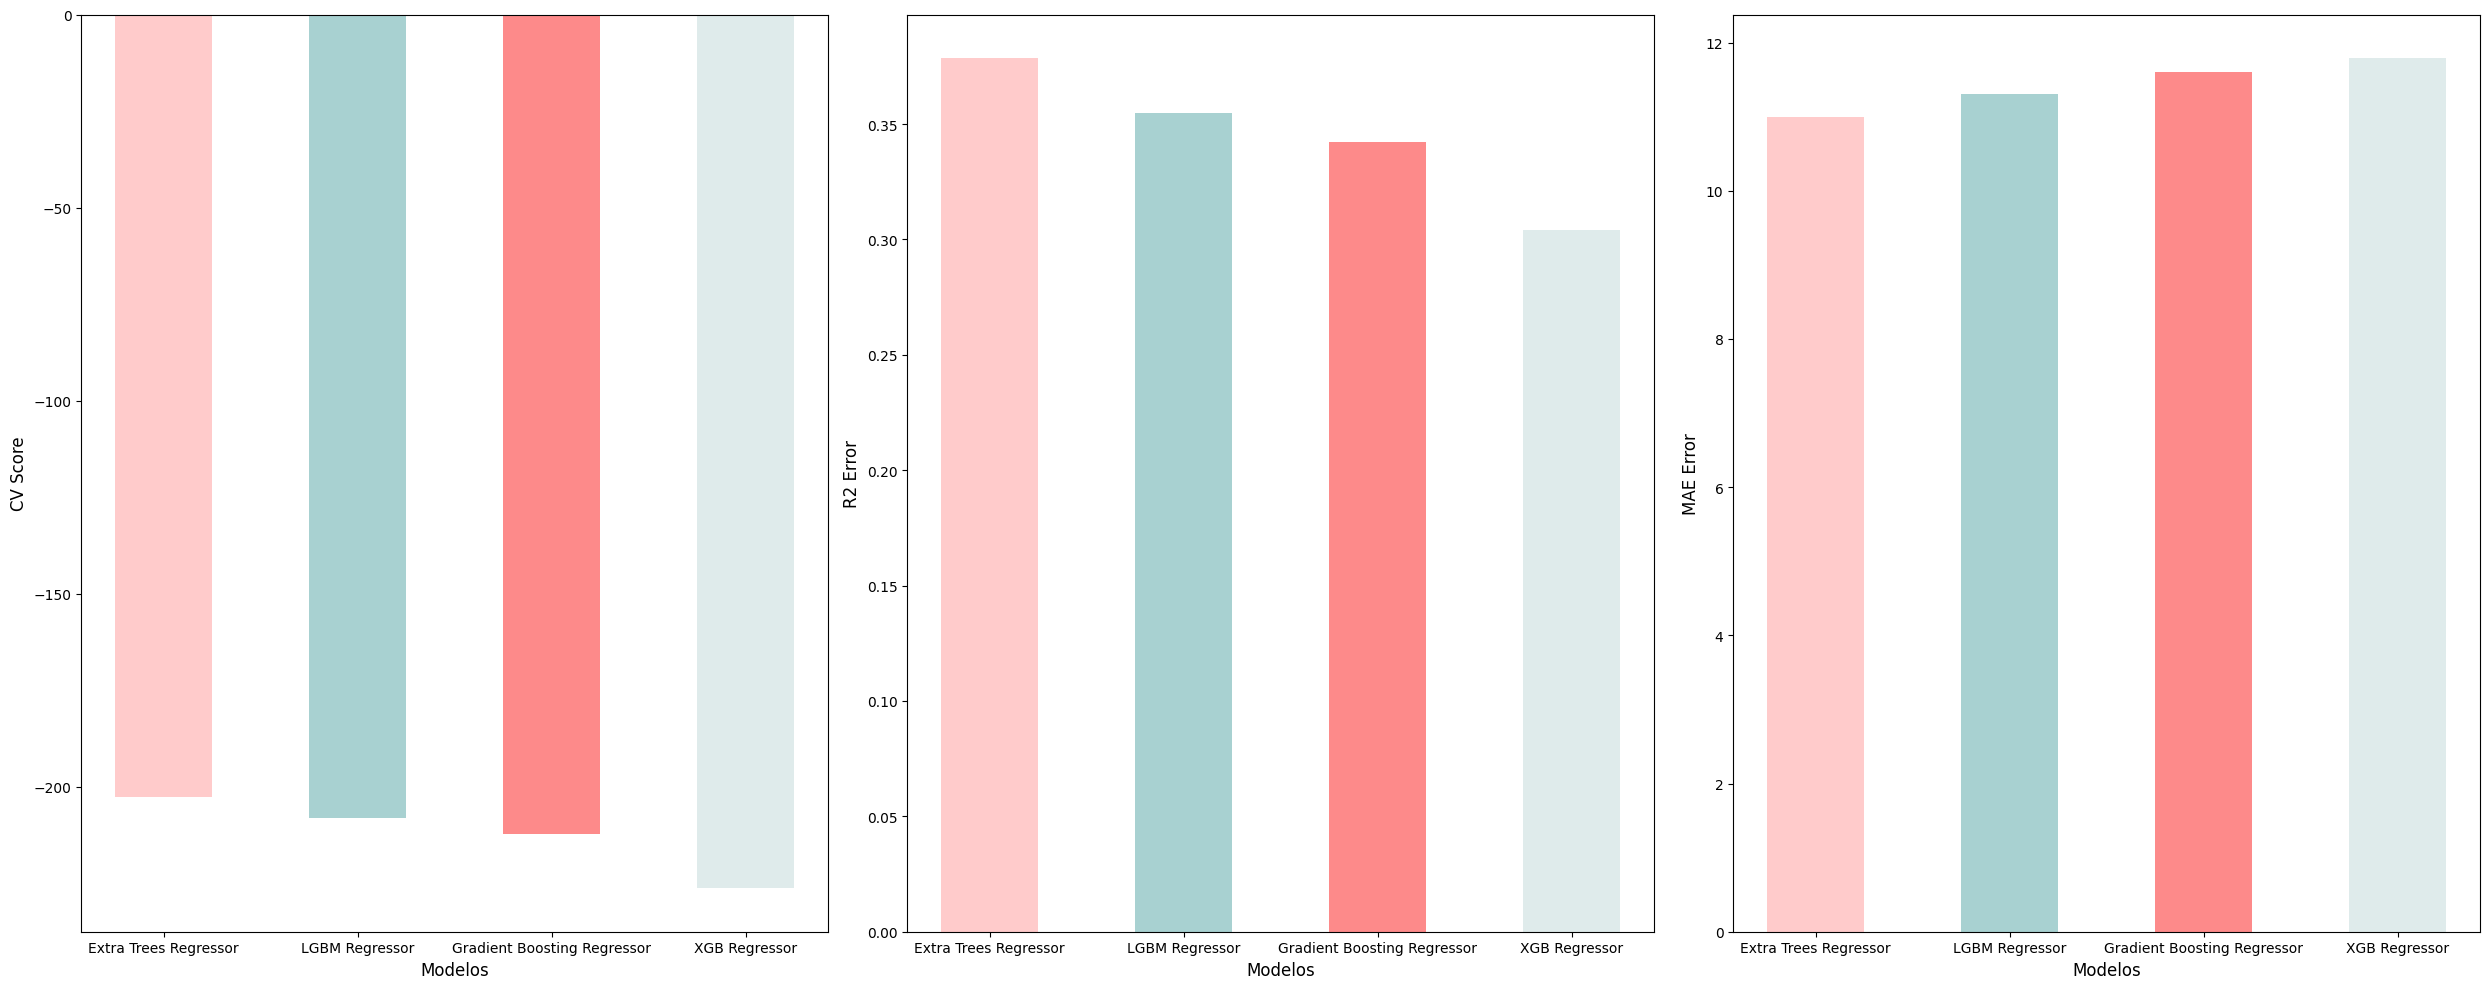

In [ ]:
colors = ['#FFCBCB', '#A8D1D1', '#FD8A8A', '#DFEBEB']

fig, axs = plt.subplots(1, 3, figsize=(25,10))

axs[0].bar(['Extra Trees Regressor', 'LGBM Regressor', 'Gradient Boosting Regressor', 'XGB Regressor'],
           errors_pc, width=0.5, color=colors)
axs[0].set_xlabel('Modelos', fontdict={'fontsize': 12})
axs[0].set_ylabel('CV Score', fontdict={'fontsize': 12})

axs[1].bar(['Extra Trees Regressor', 'LGBM Regressor', 'Gradient Boosting Regressor', 'XGB Regressor'],
           scores_pc, width=0.5, color=colors)
axs[1].set_xlabel('Modelos', fontdict={'fontsize': 12})
axs[1].set_ylabel('R2 Error', fontdict={'fontsize': 12})

# mae_scores.append(mae)
axs[2].bar(['Extra Trees Regressor', 'LGBM Regressor', 'Gradient Boosting Regressor', 'XGB Regressor'],
           mae_scores_pc, width=0.5, color=colors)
axs[2].set_xlabel('Modelos', fontdict={'fontsize': 12})
axs[2].set_ylabel('MAE Error', fontdict={'fontsize': 12})

plt.tight_layout()
plt.show()

## **2. DIMENSIONALITY REDUCTION TRAINING**

In the following sections, we will attempt to improve the results of our top 3 models so far: ExtraTrees, LGBM Regressor, and RandomForest.

### **2.1 PCA**

There are varying ways to handle our data. One of the techniques is through dimensionality reduction. For this, we will focus on studying two main techniques: `PCA` and `Truncated SVD`. For each of our models, we will analyze the effect of these two techniques.

First of all, we are going to perform a quick analysis to test the number of dimensionality to which it would be convenient to reduce our dataset. We will consider that we can reduce to $n$ dimensions when at least 90% of the variance can be explained.

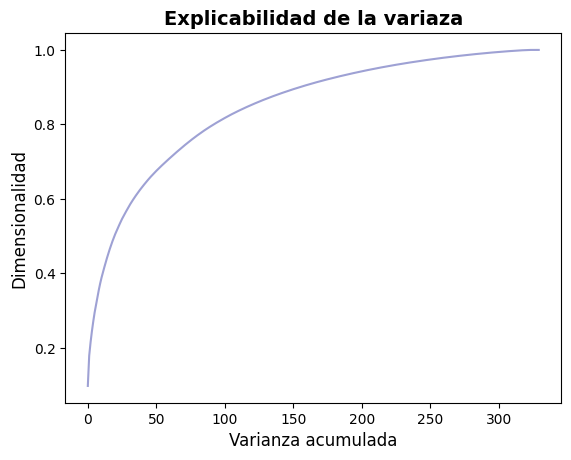

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=X_train.shape[-1], random_state=0).fit(X_scaled)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='#9EA1D4')
plt.title('Explicabilidad de la variaza', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Varianza acumulada', fontdict={'fontsize': 12})
plt.ylabel('Dimensionalidad', fontdict={'fontsize': 12})
plt.show()

**90%** of the variance is explained with 150 components.

In [ ]:
errors_pca = {'ExtraTrees': [], 'Random Forest': [], 'LGBM Regressor': []}

#### **2.1.1 ExtraTrees**

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

n_features = [x for x in range(150, X_train.shape[1] + 1, 50)]

for n in n_features:
  print(f'\n{n} componentes')
  pca = PCA(n_components=n, random_state=0)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.transform(X_val)

  et = make_pipeline(StandardScaler(),
                      ExtraTreesRegressor(n_estimators=400,
                                            max_depth=None ,
                                            min_samples_split=2,
                                            n_jobs=-1,
                                            random_state=0))
  et.fit(X_train_pca, y_train)
  y_preds = et.predict(X_val_pca)

  cv_score = cross_val_score(et, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
  score = et.score(X_val_pca, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_pca['ExtraTrees'].append(cv_score.mean())

  print('------------------------------------------')


150 componentes
cv_score: -237.32611325913268
R2 Error: 27.131477950952 %
Error MSE: 238.43257977846497
Error MAE: 12.13531796875
------------------------------------------

200 componentes
cv_score: -237.98246672675242
R2 Error: 26.869450673770924 %
Error MSE: 239.28995739384405
Error MAE: 12.15755685763889
------------------------------------------

250 componentes
cv_score: -238.43286365079751
R2 Error: 26.997373971030935 %
Error MSE: 238.87138047034145
Error MAE: 12.136201736111111
------------------------------------------

300 componentes
cv_score: -238.82397885797346
R2 Error: 26.658445534125107 %
Error MSE: 239.98038583094618
Error MAE: 12.142210590277777
------------------------------------------


#### **2.1.2 Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
for n in n_features:
  print(f'\n{n} componente(s)')
  pca = PCA(n_components=n)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.transform(X_val)
  # X_test_pca = pca.transform(X_test )
  tree = make_pipeline(StandardScaler(),
                      RandomForestRegressor(n_estimators= 200,
                                 criterion='squared_error',
                                 n_jobs=-1,
                                 random_state=0))
  tree.fit(X_train_pca, y_train)
  y_preds = tree.predict(X_val_pca)

  cv_score = cross_val_score(tree, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
  score = tree.score(X_val_pca, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_pca['Random Forest'].append(cv_score.mean())

  print('------------------------------------------')


150 componente(s)
cv_score: -238.69405509565595
R2 Error: 26.347127389462976 %
Error MSE: 240.9990477480038
Error MAE: 12.263011294642858
------------------------------------------

200 componente(s)
cv_score: -239.05703101445474
R2 Error: 26.269585384542427 %
Error MSE: 241.2527723982987
Error MAE: 12.289446343419312
------------------------------------------

250 componente(s)
cv_score: -239.8730474448551
R2 Error: 26.49780385751612 %
Error MSE: 240.5060203339767
Error MAE: 12.258238892609127
------------------------------------------

300 componente(s)
cv_score: -239.6898537579885
R2 Error: 26.13030991534807 %
Error MSE: 241.70849468394508
Error MAE: 12.273544343772548
------------------------------------------


#### **2.1.3 LGBM Regressor**

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

np.random.seed(0)

for n in n_features:
  print(f'\n{n} componente(s)')
  pca = PCA(n_components=n)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.transform(X_val)

  lgbm = make_pipeline(StandardScaler(),
                   LGBMRegressor(n_estimators=500,
                           learning_rate=0.1,
                           max_depth=-1,
                           min_child_samples=20,
                           random_state=0, force_col_wise= True))
  lgbm.fit(X_train_pca, y_train)
  y_preds = lgbm.predict(X_val_pca)

  cv_score = cross_val_score(lgbm, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
  score = lgbm.score(X_val_pca, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_pca['LGBM Regressor'].append(cv_score.mean())

  print('------------------------------------------')


150 componente(s)
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 150
[LightGBM] [Info] Start training from score 41.167708
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.192969
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.149544
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.205990
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.082682
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of dat

#### **2.1.5 PLOTS**

In [ ]:
errors_pca

{'ExtraTrees': [-237.32611325913268,
  -237.98246672675242,
  -238.43286365079751,
  -238.82397885797346],
 'Random Forest': [-238.69405509565595,
  -239.05703101445474,
  -239.8730474448551,
  -239.6898537579885],
 'LGBM Regressor': [-246.1447132748686,
  -246.52053003911723,
  -247.42812257883028,
  -246.06324944801264]}

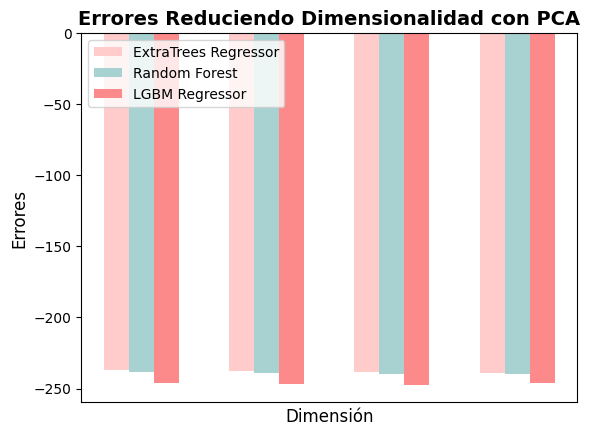

In [ ]:
x = np.array([1, 2, 3, 4])

plt.figure()

plt.bar(x - 0.4, errors_pca['ExtraTrees'], color=colors[0], width=0.2, label='ExtraTrees Regressor', align='center')
plt.bar(x - 0.2, errors_pca['Random Forest'], color=colors[1], width=0.2, label='Random Forest', align='center')
plt.bar(x, errors_pca['LGBM Regressor'], color=colors[2], width=0.2, label='LGBM Regressor', align='center')


plt.title("Errores Reduciendo Dimensionalidad con PCA", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Dimensión", fontdict={'fontsize': 12})
plt.ylabel("Errores", fontdict={'fontsize': 12})
plt.legend(loc='upper left')
plt.xticks(n_features)
plt.axis("tight")

plt.show()

### **2.2 TRUNCATED SVD**

In [ ]:
errors_svd = {'ExtraTrees': [], 'Random Forest': [], 'LGBM Regressor': []}

#### **2.2.1 ExtraTrees**

In [ ]:
from sklearn.decomposition import TruncatedSVD


n_features = [x for x in range(150, X_train.shape[1] + 1,50)]

for n in n_features:
  print(f'\n{n} componente(s)')
  svd = TruncatedSVD(n_components=n)
  X_train_svd = svd.fit_transform(X_train)
  X_val_svd = svd.transform(X_val)
  et = make_pipeline(StandardScaler(),
                    ExtraTreesRegressor(n_estimators=400,
                                            max_depth=None ,
                                            min_samples_split=2,
                                            n_jobs=-1,
                                            random_state=0))
  et.fit(X_train_svd, y_train)
  y_preds = et.predict(X_val_svd)

  cv_score = cross_val_score(et, X_train_svd, y_train, cv=5, scoring='neg_mean_squared_error')
  score = et.score(X_val_svd, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_svd['ExtraTrees'].append(cv_score.mean())

  print('------------------------------------------')



150 componente(s)
cv_score: -235.88488128028249
R2 Error: 27.23127607687462 %
Error MSE: 238.1060310307798
Error MAE: 12.044837239583334
------------------------------------------

200 componente(s)
cv_score: -236.4088250094582
R2 Error: 27.117584615902945 %
Error MSE: 238.47804006260853
Error MAE: 12.068234114583333
------------------------------------------

250 componente(s)
cv_score: -237.07055135420288
R2 Error: 27.394726658903533 %
Error MSE: 237.571205528031
Error MAE: 12.038255642361111
------------------------------------------

300 componente(s)
cv_score: -236.61212365296765
R2 Error: 26.765646731620517 %
Error MSE: 239.62961354470488
Error MAE: 12.11024861111111
------------------------------------------


#### **2.2.2 Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
for n in n_features:
  print(f'\n{n} componente(s)')
  svd = TruncatedSVD(n_components=n)
  X_train_svd = svd.fit_transform(X_train)
  X_val_svd = svd.transform(X_val)

  tree = make_pipeline(StandardScaler(),
                       RandomForestRegressor(n_estimators= 200,
                                 criterion='squared_error',
                                 n_jobs=-1,
                                 random_state=0))
  tree.fit(X_train_svd, y_train)
  y_preds = tree.predict(X_val_svd)

  cv_score = cross_val_score(tree, X_train_svd, y_train, cv=5, scoring='neg_mean_squared_error')
  score = tree.score(X_val_svd, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_svd['Random Forest'].append(cv_score.mean())

  print('------------------------------------------')



150 componente(s)
cv_score: -236.99607181654955
R2 Error: 26.817141488140383 %
Error MSE: 239.4611179131641
Error MAE: 12.209817796266234
------------------------------------------

200 componente(s)
cv_score: -237.5626805460826
R2 Error: 27.104255041633373 %
Error MSE: 238.52165566906072
Error MAE: 12.20444938792689
------------------------------------------

250 componente(s)
cv_score: -238.5371313024496
R2 Error: 26.763721328217184 %
Error MSE: 239.63591364367304
Error MAE: 12.227966537285052
------------------------------------------

300 componente(s)
cv_score: -238.22719300224838
R2 Error: 26.771247232376016 %
Error MSE: 239.61128818547382
Error MAE: 12.224020614778741
------------------------------------------


#### **2.2.4 LGBM Regressor**

In [ ]:
n_features = [x for x in range(150, X_train.shape[1] + 1,50)]

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

for n in n_features:
  print(f'\n{n} componente(s)')
  svd = TruncatedSVD(n_components=n)
  X_train_svd = svd.fit_transform(X_train)
  X_val_svd = svd.transform(X_val)
  lgbm = make_pipeline(StandardScaler(),
                   LGBMRegressor(n_estimators=500,
                           learning_rate=0.1,
                           max_depth=-1,
                           min_child_samples=20,
                           random_state=0, force_col_wise= True))
  lgbm.fit(X_train_svd, y_train)
  y_preds = lgbm.predict(X_val_svd)

  cv_score = cross_val_score(lgbm, X_train_svd, y_train, cv=5, scoring='neg_mean_squared_error')
  score = lgbm.score(X_val_svd, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_svd['LGBM Regressor'].append(cv_score.mean())

  print('------------------------------------------')


150 componente(s)
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 150
[LightGBM] [Info] Start training from score 41.167708
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.192969
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.149544
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.205990
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.082682
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of dat

#### **2.2.5 PLOTS**

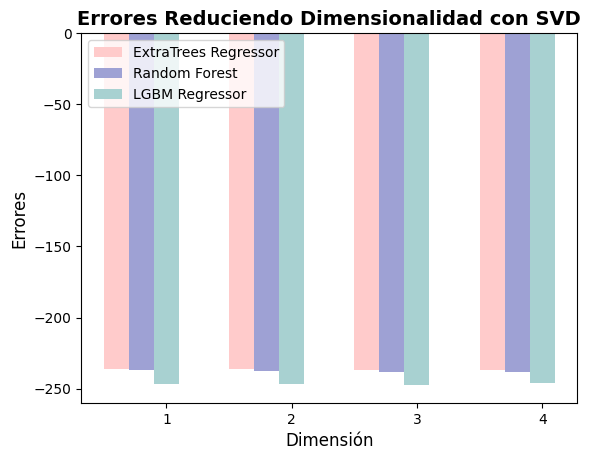

In [ ]:
x = np.array([1,2,3,4])

plt.figure()

colors= ['#FFCBCB', '#9EA1D4', '#A8D1D1']

plt.bar(x - 0.4, errors_svd['ExtraTrees'], color=colors[0], width=0.2, label='ExtraTrees Regressor', align='center')
plt.bar(x - 0.2, errors_svd['Random Forest'], color=colors[1], width=0.2, label='Random Forest', align='center')
plt.bar(x, errors_svd['LGBM Regressor'], color=colors[2], width=0.2, label='LGBM Regressor', align='center')

plt.title("Errores Reduciendo Dimensionalidad con SVD", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Dimensión", fontdict={'fontsize': 12})
plt.ylabel("Errores", fontdict={'fontsize': 12})
plt.legend(loc='upper left')
plt.xticks(x)
plt.axis("tight")

plt.show()

## **3. FEATURE SELECTION**

Feature selection is based on evaluating the relative importance of each feature in relation to the prediction objective, either by statistical methods, machine learning algorithms or specific techniques designed for this purpose.

### **3.1 FEATURE IMPORTANCE w/ LASSO**

First of all, we will perform an analysis to get an idea of the importance of the features and then we will apply different feature selection methods. We will use Lasso which penalizes some coefficients to zero, so the features associated with those coefficients will have less importance.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
hyper_params = {'alpha': [0.001, 0.01, 0.1, 1.0],
                'selection': ['cyclic', 'random']}

np.random.seed(42)

grid_lasso = GridSearchCV(Lasso(max_iter=3000), hyper_params, cv=5)
grid_lasso.fit(X_train, y_train)

grid_lasso.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.022e+03, tolerance: 5.071e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+06, tolerance: 5.047e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e+06, tolerance: 5.046e

{'alpha': 0.01, 'selection': 'cyclic'}

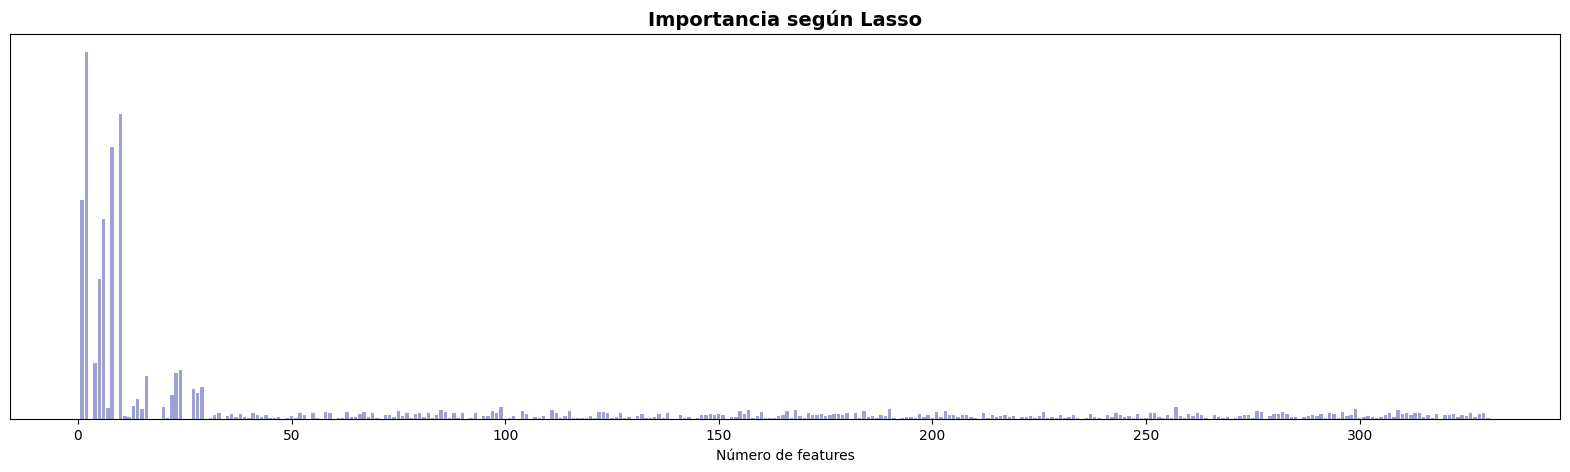

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01,
              selection='cyclic')
lasso.fit(X_train, y_train)

feature_importances = np.abs(lasso.coef_)
x = n_features = [x for x in range(1, X_train.shape[1] + 1)]

plt.figure(figsize=(20,5))
plt.bar(x, feature_importances, color='#9EA1D4')
plt.xlabel('Número de features')
plt.title('Importancia según Lasso', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.yticks(())
plt.axis("tight")
plt.show()

In [ ]:
# We counted important coefficients
coeficientes_importantes = np.sum(np.abs(lasso.coef_) > 0.1)

print(f"Número de coeficientes importantes: {coeficientes_importantes}")

Número de coeficientes importantes: 163


Considering the importance threshold 0.1, we will perform one with Select k-best of 150 features.

### **3.2 SELECT K BEST**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


errors_kbest = {'ET': [], 'RF': [], 'LGBM': []}
scores_kbest = {'ET': [], 'RF': [], 'LGBM': []}

nfs = [150]

for n in nfs:
    np.random.seed(42)
    print(f'SELECT K BEST CON K={n}')

    # ExtraTrees
    print('\nExtraTrees REGRESSOR\n')
    et = make_pipeline(SelectKBest(k=n),StandardScaler(),
                      ExtraTreesRegressor(n_estimators=400,
                                            max_depth=None ,
                                            min_samples_split=2,
                                            n_jobs=-1,
                                            random_state=0))
    et.fit(X_train, y_train)

    cv_score_1 = cross_val_score(et, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_1 = et.score(X_val, y_val)

    print(f'cv_score ET: {cv_score_1.mean()}')
    print(f'R2 Error ET: {r2_1 * 100} %')

    errors_kbest['ET'].append(cv_score_1.mean())
    scores_kbest['ET'].append(r2_1)

    # Random Forest
    print('\nRandom Forest REGRESSOR\n')
    tree = make_pipeline(SelectKBest(k=n),StandardScaler(),
                        RandomForestRegressor(n_estimators= 200,
                                 criterion='squared_error',
                                 n_jobs=-1,
                                 random_state=0))

    tree.fit(X_train, y_train)

    cv_score_2 = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_2 = tree.score(X_val, y_val)

    print(f'cv_score RF: {cv_score_2.mean()}')
    print(f'R2 Error RF: {r2_2 * 100} %')

    errors_kbest['RF'].append(cv_score_2.mean())
    scores_kbest['RF'].append(r2_2)

    # LGBM Regressor
    print('\nLGBM REGRESSOR\n')
    lgbm = make_pipeline(SelectKBest(k=n),StandardScaler(),
                   LGBMRegressor(n_estimators=500,
                           learning_rate=0.1,
                           max_depth=-1,
                           min_child_samples=20,
                           random_state=0, force_col_wise= True))
    lgbm.fit(X_train, y_train)


    cv_score_3 = cross_val_score(lgbm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_3 = lgbm.score(X_val, y_val)

    print(f'cv_score LGBM: {cv_score_3.mean()}')
    print(f'R2 Error LGBM: {r2_3 * 100} %')

    errors_kbest['LGBM'].append(cv_score_3.mean())
    scores_kbest['LGBM'].append(r2_3)

    print('---------------------------------------------------------------------------\n')

SELECT K BEST CON K=150

ExtraTrees REGRESSOR



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


cv_score ET: -200.57905831990558
R2 Error ET: 38.192299706657195 %

Random Forest REGRESSOR



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


cv_score RF: -203.28555912642787
R2 Error RF: 36.89775412287698 %

LGBM REGRESSOR

[LightGBM] [Info] Total Bins 36603
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 150
[LightGBM] [Info] Start training from score 41.167708
[LightGBM] [Info] Total Bins 36598
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.192969
[LightGBM] [Info] Total Bins 36599
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.149544
[LightGBM] [Info] Total Bins 36596
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.205990
[LightGBM] [Info] Total Bins 36599
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.082682


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Total Bins 36598
[LightGBM] [Info] Number of data points in the train set: 15360, number of used features: 150
[LightGBM] [Info] Start training from score 41.207357
cv_score LGBM: -207.11055064988358
R2 Error LGBM: 35.81852467614519 %
---------------------------------------------------------------------------



#### **PLOTS**

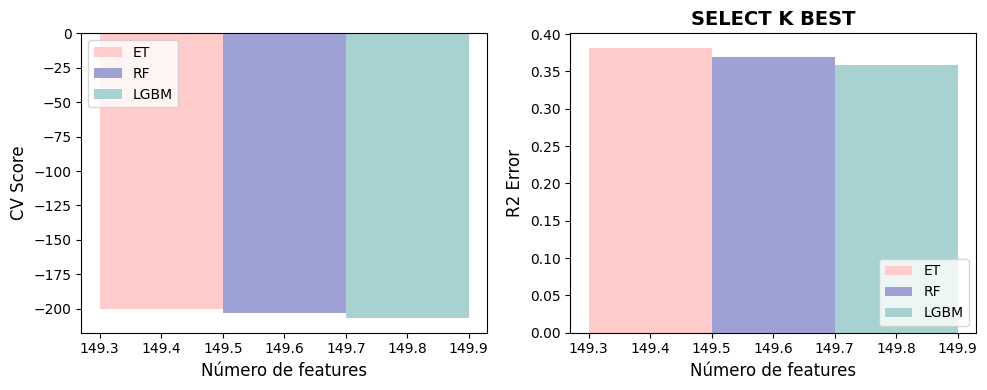

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
x = np.array(nfs)
colors= ['#FFCBCB', '#9EA1D4', '#A8D1D1']

for model, color, offset in zip(errors_kbest.keys(), colors, [0.6, 0.4, 0.2, 0.00]):
    axs[0].bar(x - offset, errors_kbest[model], color=color, width=0.2, label=model, align='center')
axs[0].set_xlabel('Número de features', fontdict={'fontsize': 12})
axs[0].set_ylabel('CV Score', fontdict={'fontsize': 12})
axs[0].legend(loc='upper left')

for model, color, offset in zip(scores_kbest.keys(), colors, [0.6, 0.4, 0.2, 0.00]):
    axs[1].bar(x - offset, scores_kbest[model], color=color, width=0.2, label=model, align='center')
axs[1].set_xlabel('Número de features', fontdict={'fontsize': 12})
axs[1].set_ylabel('R2 Error', fontdict={'fontsize': 12})
axs[1].legend(loc='lower right')

plt.title('SELECT K BEST', fontdict={'fontsize': 14, 'fontweight': 'bold'}, loc='center')
plt.tight_layout()
plt.show()

Se puede observar que hemos conseguido mejorar nuestro modelo inicial de Extra Trees Regressor, pasando de un cv_score: -202.469 y R2 Score: 37.855% a -200.579 y 38.192 %. En nuestro último apartado, utilizaremos este modelo para predecir la popularidad de una nueva selección de canciones.

## **4. RESULTS AND PREDICTION OF NEW DATA**

In [ ]:
songs_test = pd.read_csv('test_ap1_mcp_23_24_test.csv')

In [ ]:
id = songs_test['song_id']

In [ ]:
et = make_pipeline(SelectKBest(k=150),StandardScaler(),
                      ExtraTreesRegressor(n_estimators=400,
                                            max_depth=None ,
                                            min_samples_split=2,
                                            n_jobs=-1,
                                            random_state=0))
et.fit(X_train, y_train)

**Data prediction**

In [ ]:
songs_test['title_length'] = songs_test['song_name'].apply(lambda x: len(x))
X = songs_test
X = pd.get_dummies(X, columns=['key', 'audio_mode', 'time_signature'])
X

,song_name,song_id,acousticness,danceability,song_duration_ms,energy,instrumentalness,liveness,loudness,speechiness,...,key_8,key_9,key_10,key_11,audio_mode_0,audio_mode_1,time_signature_1,time_signature_2,time_signature_3,time_signature_4
0,sunlight,163768,0.82900,0.625,203667,0.324,0.960000,0.1150,-10.729,0.0287,...,0,0,0,0,1,0,0,0,1,0
1,Avant de quitter (Faust),993666,0.99500,0.174,246773,0.249,0.711000,0.0621,-11.343,0.0363,...,0,0,0,0,1,0,0,0,1,0
2,Destiny,193666,0.00388,0.614,200008,0.863,0.001560,0.2300,-6.096,0.0763,...,0,0,0,0,0,1,0,0,1,0
3,We Almost Lost Detroit,198820,0.91100,0.437,257173,0.232,0.000000,0.9740,-23.147,0.2980,...,0,0,0,0,1,0,0,0,1,0
4,Suga Suga,371820,0.65700,0.701,239027,0.750,0.000003,0.0845,-3.191,0.2740,...,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,Riptide (Pluto Tapes),867491,0.38800,0.585,193973,0.685,0.000000,0.1100,-6.490,0.0502,...,0,0,0,0,0,1,0,0,1,0
5996,Sleepy Eyes,21619,0.05100,0.608,202887,0.736,0.000000,0.2150,-6.700,0.1650,...,0,1,0,0,1,0,0,0,1,0
5997,Martyrdom of St. Victor,613505,0.48400,0.666,102347,0.280,0.000000,0.1530,-14.667,0.8520,...,0,0,1,0,1,0,0,1,0,0
5998,Air Supply Bachata Medley,307822,0.09320,0.772,282000,0.761,0.000002,0.0450,-7.170,0.0274,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
X['song_name'] = X['song_name'].apply(limpiar_texto)
word2vec = X['song_name'].astype(str).apply(lambda x: nlp(x).vector)
# Building a DataFrame from lists in 'word2vec'.
df = pd.DataFrame(word2vec.tolist(), columns=[f'feature_{i+1}' for i in range(300)])

# Concatenate the new DataFrame with 'songs'.
songs_with_word2vec = pd.concat([X, df], axis=1)
X = songs_with_word2vec.drop('song_name', axis=1)
X= X.drop('song_id', axis=1)
X.head()

,acousticness,danceability,song_duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300
0,0.82900,0.625,203667,0.324,0.960000,0.1150,-10.729,0.0287,123.055,0.0694,...,-0.248140,-1.513000,3.403900,-1.163700,-3.438100,0.32294,4.191700,-0.48324,-2.648600,0.834000
1,0.99500,0.174,246773,0.249,0.711000,0.0621,-11.343,0.0363,71.169,0.1560,...,-0.486483,3.433681,2.049300,0.078625,0.874900,-0.94646,0.039860,3.59665,-0.595025,-3.489502
2,0.00388,0.614,200008,0.863,0.001560,0.2300,-6.096,0.0763,149.913,0.3120,...,2.575300,-0.172630,-0.952580,1.447400,1.478900,-2.36450,-1.096800,0.17030,-3.016300,2.308600
3,0.91100,0.437,257173,0.232,0.000000,0.9740,-23.147,0.2980,89.836,0.3500,...,1.299075,0.260160,-0.009975,1.044620,-1.717265,1.45540,-0.513173,2.20860,-2.861995,0.851227
4,0.65700,0.701,239027,0.750,0.000003,0.0845,-3.191,0.2740,82.531,0.5150,...,0.985200,-5.199000,1.764200,-4.675600,-1.501200,-0.26373,5.023200,2.23240,-1.820800,-0.528310


In [ ]:
X.insert(X.columns.get_loc('time_signature_1'), 'time_signature_0', 0)

In [ ]:
predicciones = et.predict(X)

In [ ]:
predicciones= pd.DataFrame(predicciones)
predicciones

,0
0,39.317500
1,22.741250
2,48.455000
3,26.842500
4,72.000000
...,...
5995,51.234583
5996,52.830000
5997,18.307083
5998,46.165000


# **Lower dimensionality dataset**

In order to support the importance of integrating the title and its semantics in the prediction of popularity, we have performed a new set of training using the dataset without including the word embedding dimensions of the title. In addition, we consider relevant to highlight the variation in predictive performance when employing one-hot coding for the columns we consider categorical.

In this section, we will detail the results obtained with the first four models on our original dataset, keeping the 'title-length' column. Given the difference of more than 310 components in the columns considered, the elimination of that column was perceived as having little influence. This approach will allow us to effectively highlight the contribution of title and categorical coding in predicting music popularity.

In [ ]:
songs = pd.read_csv('train_ap1_mcp_23_24_train.csv').set_index('song_id')

Convertion of the `song_name` column into a numeric variable.

In [ ]:
songs['title_length'] = songs['song_name'].apply(lambda x: len(x))
songs.head()

,song_name,popularity,acousticness,danceability,song_duration_ms,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,title_length
song_id,,,,,,,,,,,,,,,,
782579,I’ll Come Running (To Tie Your Shoe),34,0.5350,0.584,218227,0.459,0.034200,0,0.153,-14.127,0,0.0319,124.465,3,0.765,36
150969,Mohican,47,0.3210,0.758,206600,0.503,0.000234,0,0.121,-11.445,0,0.1600,120.027,3,0.477,7
261974,"Todo Quedó, Quedó (En Vivo) [feat. Nelsón Arri...",25,0.1680,0.732,304970,0.824,0.000021,11,0.942,-9.296,0,0.1170,102.002,3,0.826,50
360055,Be Glorified,39,0.0726,0.553,307040,0.718,0.000003,8,0.152,-6.385,0,0.0248,87.989,3,0.677,12
745239,Guilty Pleasure,57,0.0032,0.641,204435,0.844,0.000000,9,0.106,-5.758,0,0.0465,150.030,3,0.834,15


## **1. BASELINE TRAINING**

First we split the set X and y. We remove the `song_name` and `popularity` columns.

In [ ]:
X_train = songs.drop(['popularity', 'song_name'], axis=1)
y_train = songs['popularity']

Since we do not have the actual values for the test set, we will reserve a percentage of the training set to evaluate the model by cross-validation.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

Before proceeding, we will use `pycaret` again to evaluate if there is any other model with a lower error. According to the results obtained, the best model is **Random Forest**. With this result in consideration, we will perform our tests on the **first four models used in the previous section** in order to make a proper comparison of the results.

In [ ]:
from pycaret.regression import *
model_reg = setup(data = X_train, target = y_train, session_id=42, index=False)
compare_models()

,Description,Value
0,Session id,42
1,Target,popularity
2,Target type,Regression
3,Original data shape,"(19560, 15)"
4,Transformed data shape,"(19560, 15)"
5,Transformed train set shape,"(13692, 15)"
6,Transformed test set shape,"(5868, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,11.3927,216.3193,14.7043,0.3339,0.7144,0.6065,13.7620
lightgbm,Light Gradient Boosting Machine,11.4791,216.5207,14.7122,0.3330,0.7087,0.5998,0.6720
et,Extra Trees Regressor,11.3644,219.1157,14.7985,0.3253,0.7194,0.6083,4.3680
gbr,Gradient Boosting Regressor,11.7138,221.2727,14.8727,0.3185,0.7209,0.6156,3.3310
xgboost,Extreme Gradient Boosting,11.9102,236.0426,15.3606,0.2729,0.7195,0.6073,0.6600
ada,AdaBoost Regressor,12.8167,248.9130,15.7750,0.2334,0.7517,0.6772,0.7330
lr,Linear Regression,12.5761,249.6666,15.7979,0.2312,0.7614,0.7018,0.5220
ridge,Ridge Regression,12.5764,249.6658,15.7979,0.2312,0.7614,0.7019,0.0270
br,Bayesian Ridge,12.5775,249.6667,15.7979,0.2312,0.7614,0.7020,0.0330
lar,Least Angle Regression,12.5812,249.8021,15.8022,0.2307,0.7607,0.7005,0.0290


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

RandomForestRegressor(n_jobs=-1, random_state=42)

### **1.1 SGD REGRESSOR**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

hyper_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'learning_rate': ['invscaling', 'adaptive', 'optimal', 'constant']}

np.random.seed(42)

grid_sgd = GridSearchCV(SGDRegressor(), hyper_params, cv=5)
grid_sgd.fit(X_train, y_train)

grid_sgd.best_params_

{'alpha': 0.1, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'}

We create lists to store the results we obtain with each model for future visualization.

In [ ]:
errors = []
scores = []

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

sgd = make_pipeline(StandardScaler(),
                    SGDRegressor(alpha=grid_sgd.best_params_['alpha'],
                                 penalty=grid_sgd.best_params_['penalty'],
                                 learning_rate=grid_sgd.best_params_['learning_rate'],
                                 random_state=0))
sgd.fit(X_train, y_train)
y_preds = sgd.predict(X_val)

cv_score = cross_val_score(sgd, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score = sgd.score(X_val, y_val)
mse = mean_squared_error(y_val, y_preds)
mae = mean_absolute_error(y_val, y_preds)

print(f'cv_score: {cv_score.mean()} ')
print(f'R2 Error: {score * 100} %')
print(f'Error MSE: {mse}')
print(f'Error MAE: {mae}')

errors.append(cv_score.mean())
scores.append(score)

cv_score: -249.13015138176348 
R2 Error: 21.517757394574122 %
Error MSE: 256.80119542723077
Error MAE: 12.829912805666002


### **1.2 RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

During the process, we have executed the following cells. The first one is about the search for the optimal hyperparameters using `GridSearchCV`. As this process has been very slow and time consuming we have saved the results in a variable, so that every time we need to run the code we get the hyperparameters from this pickles file instead of having to run this code.

```
hyper_params = {'n_estimators': [100, 1000],
                'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']}

np.random.seed(42)

grid_tree = GridSearchCV(RandomForestRegressor(n_jobs=-1), hyper_params, cv=5)
grid_tree.fit(X_train, y_train)

grid_tree.best_params_
```

We save the variable in a pickle file so that when executing the code, we do not have to wait for `GridSearchCV()` to finish and we can read the variable directly from the pickle file.
```
import pickle

with open('tree_best_params.pkl', 'wb') as file:
    pickle.dump(grid_tree.best_params_, file)
```

In [ ]:
import pickle
with open('tree_best_params.pkl', 'rb') as file:
    tree_best_params = pickle.load(file)

print(tree_best_params)

{'criterion': 'squared_error', 'n_estimators': 1000}


We train the model according to the hyperparameters we have found.

In [ ]:
tree = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_estimators=tree_best_params['n_estimators'],
                                 criterion=tree_best_params['criterion'],
                                 n_jobs=-1,
                                 random_state=0))
tree.fit(X_train, y_train)
y_preds = tree.predict(X_val)

cv_score = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score = tree.score(X_val, y_val)
mse = mean_squared_error(y_val, y_preds)
mae = mean_absolute_error(y_val, y_preds)

print(f'cv_score: {cv_score.mean()}')
print(f'R2 Error: {score * 100} %')
print(f'Error MSE: {mse}')
print(f'Error MAE: {mae}')

errors.append(cv_score.mean())
scores.append(score)

cv_score: -204.77148224833957
R2 Error: 37.38003260775402 %
Error MSE: 204.89835598595934
Error MAE: 11.176331303368507


We get better results than with `SGDRegressor`.

### **1.3 SVM REGRESSOR**

The next model we are going to consider is the Support Vector Machines for regression. As with RAndom Forest, the process of finding the best hyperparameters has been very long, so we repeat the procedure.

In [ ]:
from sklearn.svm import SVR

```
hyper_params = {'kernel': ['linear', 'poly', 'sigmoid'],
                'degree': [3, 4, 5],
                'gamma': ['scale', 'auto'],
                'C': [1.0, 10.0]}

np.random.seed(42)

grid_svm = GridSearchCV(SVR(), hyper_params, cv=5)
grid_svm.fit(X_train, y_train)

grid_svm.best_params_
```

```
import pickle

with open('svr_best_params.pkl', 'wb') as file:
    pickle.dump(grid_svm.best_params_, file)
```

In [ ]:
with open('svr_best_params.pkl', 'rb') as file:
    svr_best_params = pickle.load(file)

print(svr_best_params)

{'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'C': 10.0}


In [ ]:
np.random.seed(0)

svr = make_pipeline(StandardScaler(),
                    SVR(kernel=svr_best_params['kernel'],
                        gamma=svr_best_params['gamma'],
                        C=svr_best_params['C']))
svr.fit(X_train, y_train)
y_preds = svr.predict(X_val)

cv_score = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score = svr.score(X_val, y_val)
mse = mean_squared_error(y_val, y_preds)
mae = mean_absolute_error(y_val, y_preds)

print(f'cv_score: {cv_score.mean()}')
print(f'R2 Error: {score * 100} %')
print(f'Error MSE: {mse}')
print(f'Error MAE: {mae}')

errors.append(cv_score.mean())
scores.append(score)

cv_score: -259.9803933942429
R2 Error: 23.57765651938053 %
Error MSE: 250.0610139524315
Error MAE: 12.249672885032412


### **1.4 MLP REGRESSOR**

Finally, we will train a Multi Layer Perceptron with which we will repeat the process followed in the previous cases.

In [ ]:
from sklearn.neural_network import MLPRegressor

```
hyper_params = {'solver': ['adam', 'sgd'],
                'activation': ['relu', 'logistic', 'identity', 'tanh'],
                'learning_rate': ['constant', 'invscaling', 'adaptive']}

np.random.seed(42)

grid_mlp = GridSearchCV(MLPRegressor(max_iter=3000,
                                     hidden_layer_sizes=100), hyper_params, cv=5)
grid_mlp.fit(X_train, y_train)

grid_mlp.best_params_
```

```
import pickle

with open('mlp_best_params.pkl', 'wb') as file:
    pickle.dump(grid_mlp.best_params_, file)
```

In [ ]:
with open('mlp_best_params.pkl', 'rb') as file:
    mlp_best_params = pickle.load(file)

print(mlp_best_params)

{'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [ ]:
mlp = make_pipeline(StandardScaler(),
                    MLPRegressor(hidden_layer_sizes=100,
                                 solver=mlp_best_params['solver'],
                                 activation=mlp_best_params['activation'],
                                 learning_rate=mlp_best_params['learning_rate'],
                                 max_iter=3000,
                                 random_state=0))
mlp.fit(X_train, y_train)
y_preds = mlp.predict(X_val)

cv_score = cross_val_score(mlp, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
score = mlp.score(X_val, y_val)
mse = mean_squared_error(y_val, y_preds)
mae = mean_absolute_error(y_val, y_preds)

print(f'cv_score: {cv_score.mean()}')
print(f'R2 Error: {score * 100} %')
print(f'Error MSE: {mse}')
print(f'Error MAE: {mae}')

errors.append(cv_score.mean())
scores.append(score)

cv_score: -249.47932076454828
R2 Error: 26.295380668896307 %
Error MSE: 241.16836782933441
Error MAE: 12.236308202672681


### **1.5 PLOTS**

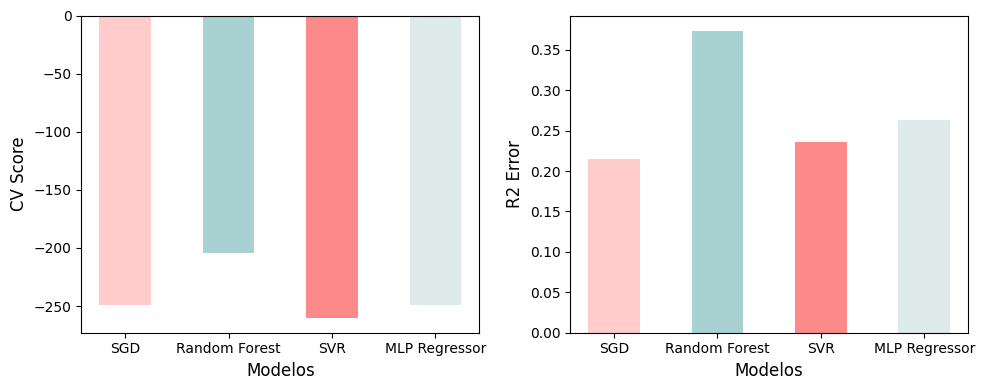

In [ ]:
colors = ['#FFCBCB', '#A8D1D1', '#FD8A8A', '#DFEBEB']

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].bar(['SGD', 'Random Forest', 'SVR', 'MLP Regressor'],
           errors, width=0.5, color=colors)
axs[0].set_xlabel('Modelos', fontdict={'fontsize': 12})
axs[0].set_ylabel('CV Score', fontdict={'fontsize': 12})

axs[1].bar(['SGD', 'Random Forest', 'SVR', 'MLP Regressor'],
           scores, width=0.5, color=colors)
axs[1].set_xlabel('Modelos', fontdict={'fontsize': 12})
axs[1].set_ylabel('R2 Error', fontdict={'fontsize': 12})

plt.tight_layout()
plt.show()

## **2. DIMENSIONALITY REDUCTION TRAINING**

### **2.1 PCA**

First of all, we are going to perform a quick analysis to test the number of dimensionality to which it would be convenient to reduce our dataset. We will consider that we can reduce to $n$ dimensions when at least 90% of the variance can be explained.

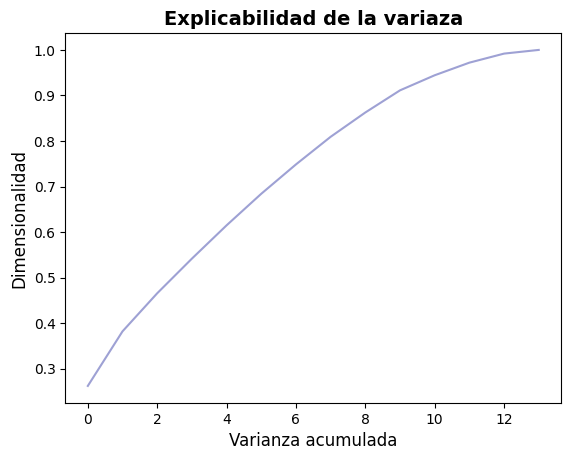

In [ ]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=X_train.shape[-1], random_state=0).fit(X_scaled)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='#9EA1D4')
plt.title('Explicabilidad de la variaza', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Varianza acumulada', fontdict={'fontsize': 12})
plt.ylabel('Dimensionalidad', fontdict={'fontsize': 12})
plt.show()

**90%** of the variance is explained by 9 components.

In [ ]:
errors_pca = {'SGD': [], 'RF': [], 'SVR': [], 'MLP': []}

#### **2.1.1 SGD REGRESSOR**

In [ ]:
from sklearn.decomposition import PCA

n_features = [x for x in range(9, X_train.shape[1] + 1)]

for n in n_features:
  print(f'\n{n} componentes')
  pca = PCA(n_components=n, random_state=0)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.transform(X_val)
  # X_test_pca = pca.transform(X_test)
  sgd = make_pipeline(StandardScaler(),
                    SGDRegressor(alpha=grid_sgd.best_params_['alpha'],
                                 penalty=grid_sgd.best_params_['penalty'],
                                 learning_rate=grid_sgd.best_params_['learning_rate'],
                                 random_state=0))
  sgd.fit(X_train_pca, y_train)
  y_preds = sgd.predict(X_val_pca)

  cv_score = cross_val_score(sgd, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
  score = sgd.score(X_val_pca, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_pca['SGD'].append(cv_score.mean())

  print('------------------------------------------')


9 componentes
cv_score: -249.13015138176348
R2 Error: 15.013095708801472 %
Error MSE: 278.0850532949803
Error MAE: 13.512889663907695
------------------------------------------

10 componentes
cv_score: -249.13015138176348
R2 Error: 15.304553122751873 %
Error MSE: 277.1313775355491
Error MAE: 13.449583087753348
------------------------------------------

11 componentes
cv_score: -249.13015138176348
R2 Error: 19.19117581157578 %
Error MSE: 264.41398670253574
Error MAE: 12.992920184497468
------------------------------------------

12 componentes
cv_score: -249.13015138176348
R2 Error: 21.150935136064387 %
Error MSE: 258.00147196581304
Error MAE: 12.850743496985883
------------------------------------------

13 componentes
cv_score: -249.13015138176348
R2 Error: 21.49452397524033 %
Error MSE: 256.8772173356359
Error MAE: 12.83207011832692
------------------------------------------

14 componentes
cv_score: -249.13015138176348
R2 Error: 21.69041938245527 %
Error MSE: 256.2362293480166
Er

#### **2.1.2 RANDOM FOREST**

In [ ]:
for n in n_features:
  print(f'\n{n} componente(s)')
  pca = PCA(n_components=n)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.transform(X_val)
  # X_test_pca = pca.transform(X_test )
  tree = make_pipeline(StandardScaler(),
                       RandomForestRegressor(
                          n_estimators=tree_best_params['n_estimators'],
                          criterion=tree_best_params['criterion'],
                          n_jobs=-1,
                          random_state=0))
  tree.fit(X_train_pca, y_train)
  y_preds = tree.predict(X_val_pca)

  cv_score = cross_val_score(tree, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
  score = tree.score(X_val_pca, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_pca['RF'].append(cv_score.mean())

  print('------------------------------------------')


9 componente(s)
cv_score: -204.77148224833954
R2 Error: 29.430002597620096 %
Error MSE: 230.91159340768925
Error MAE: 11.85244284435125
------------------------------------------

10 componente(s)
cv_score: -204.77148224833957
R2 Error: 30.76196076933688 %
Error MSE: 226.5533024185338
Error MAE: 11.727038339458574
------------------------------------------

11 componente(s)
cv_score: -204.77148224833957
R2 Error: 31.744144103940307 %
Error MSE: 223.3395072200079
Error MAE: 11.653519731661858
------------------------------------------

12 componente(s)
cv_score: -204.77148224833957
R2 Error: 34.33030096700931 %
Error MSE: 214.87736149186657
Error MAE: 11.429373495287699
------------------------------------------

13 componente(s)
cv_score: -204.77148224833957
R2 Error: 34.59062679095324 %
Error MSE: 214.025551189688
Error MAE: 11.422391101197992
------------------------------------------

14 componente(s)
cv_score: -204.77148224833957
R2 Error: 35.04669677009592 %
Error MSE: 212.533247

#### **2.1.3 SVM REGRESSOR**

In [ ]:
np.random.seed(0)

for n in n_features:
  print(f'\n{n} componente(s)')
  pca = PCA(n_components=n)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.transform(X_val)
  # X_test_pca = pca.transform(X_test )
  svr = make_pipeline(StandardScaler(),
                    SVR(kernel=svr_best_params['kernel'],
                        gamma=svr_best_params['gamma'],
                        C=svr_best_params['C']))
  svr.fit(X_train_pca, y_train)
  y_preds = svr.predict(X_val_pca)

  cv_score = cross_val_score(svr, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
  score = svr.score(X_val_pca, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_pca['SVR'].append(cv_score.mean())

  print('------------------------------------------')


9 componente(s)
cv_score: -288.1825442820375
R2 Error: 13.761669644718166 %
Error MSE: 282.1798357397313
Error MAE: 13.204639789802695
------------------------------------------

10 componente(s)
cv_score: -322.8544305006102
R2 Error: 0.7775096572518958 %
Error MSE: 324.6652145427223
Error MAE: 13.04646755380905
------------------------------------------

11 componente(s)
cv_score: -268.8479063526345
R2 Error: 11.95108839648139 %
Error MSE: 288.10422593972777
Error MAE: 12.600427906354117
------------------------------------------

12 componente(s)
cv_score: -271.768716324024
R2 Error: 23.529880739871835 %
Error MSE: 250.21734074538497
Error MAE: 12.327576673523454
------------------------------------------

13 componente(s)
cv_score: -270.0296328041782
R2 Error: 23.884473059017697 %
Error MSE: 249.05708170559453
Error MAE: 12.261620452383893
------------------------------------------

14 componente(s)
cv_score: -261.1128422060855
R2 Error: 23.337330708840977 %
Error MSE: 250.84738235

#### **2.1.4 MLP REGRESSOR**

In [ ]:
n_features = [x for x in range(9, X_train.shape[1] + 1)]

In [ ]:
for n in n_features:
  print(f'\n{n} componente(s)')
  pca = PCA(n_components=n)
  X_train_pca = pca.fit_transform(X_train)
  X_val_pca = pca.transform(X_val)
  # X_test_pca = pca.transform(X_test )
  mlp = make_pipeline(StandardScaler(),
                      MLPRegressor(hidden_layer_sizes=100,
                                 solver=mlp_best_params['solver'],
                                 activation=mlp_best_params['activation'],
                                 learning_rate=mlp_best_params['learning_rate'],
                                 max_iter=3000,
                                 random_state=0))
  mlp.fit(X_train_pca, y_train)
  y_preds = mlp.predict(X_val_pca)

  cv_score = cross_val_score(mlp, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
  score = mlp.score(X_val_pca, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_pca['MLP'].append(cv_score.mean())

  print('------------------------------------------')


9 componente(s)
cv_score: -242.07388531269848
R2 Error: 25.461311393520536 %
Error MSE: 243.8975200537742
Error MAE: 12.309014097295554
------------------------------------------

10 componente(s)
cv_score: -244.53641833308552
R2 Error: 26.519668882628945 %
Error MSE: 240.43447593870184
Error MAE: 12.226224808546108
------------------------------------------

11 componente(s)
cv_score: -241.0632534141702
R2 Error: 28.31083797378964 %
Error MSE: 234.57360412168558
Error MAE: 12.04846904857083
------------------------------------------

12 componente(s)
cv_score: -248.75376902102803
R2 Error: 26.55359031286144 %
Error MSE: 240.32348186481812
Error MAE: 12.138471915359654
------------------------------------------

13 componente(s)
cv_score: -249.34775520016856
R2 Error: 24.736767032298534 %
Error MSE: 246.26829657499718
Error MAE: 12.336543548569999
------------------------------------------

14 componente(s)
cv_score: -253.64353243257455
R2 Error: 25.756099963589662 %
Error MSE: 242.93

#### **2.1.5 GRÁFICA**

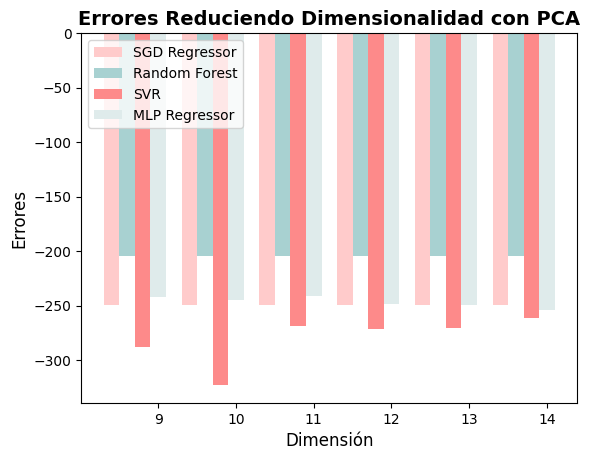

In [ ]:
x = np.array(n_features)

plt.figure()

plt.bar(x - 0.6, errors_pca['SGD'], color=colors[0], width=0.2, label='SGD Regressor', align='center')
plt.bar(x - 0.4, errors_pca['RF'], color=colors[1], width=0.2, label='Random Forest', align='center')
plt.bar(x - 0.2, errors_pca['SVR'], color=colors[2], width=0.2, label='SVR', align='center')
plt.bar(x, errors_pca['MLP'], color=colors[3], width=0.2, label='MLP Regressor', align='center')

plt.title("Errores Reduciendo Dimensionalidad con PCA", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Dimensión", fontdict={'fontsize': 12})
plt.ylabel("Errores", fontdict={'fontsize': 12})
plt.legend(loc='upper left')
plt.xticks(n_features)
plt.axis("tight")

plt.show()

### **2.2 TRUNCATED SVD**

In [ ]:
errors_svd = {'SGD': [], 'RF': [], 'SVR': [], 'MLP': []}

#### **2.2.1 SGD REGRESSOR**

In [ ]:
from sklearn.decomposition import TruncatedSVD

n_features = [x for x in range(9, X_train.shape[1] + 1)]

for n in n_features:
  print(f'\n{n} componente(s)')
  svd = TruncatedSVD(n_components=n)
  X_train_svd = svd.fit_transform(X_train)
  X_val_svd = svd.transform(X_val)
  # X_test_svd = svd.transform(X_test)
  sgd = make_pipeline(StandardScaler(),
                    SGDRegressor(alpha=grid_sgd.best_params_['alpha'],
                                 penalty=grid_sgd.best_params_['penalty'],
                                 learning_rate=grid_sgd.best_params_['learning_rate'],
                                 random_state=0))
  sgd.fit(X_train_svd, y_train)
  y_preds = sgd.predict(X_val_svd)

  cv_score = cross_val_score(sgd, X_train_svd, y_train, cv=5, scoring='neg_mean_squared_error')
  score = sgd.score(X_val_svd, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_svd['SGD'].append(cv_score.mean())

  print('------------------------------------------')



9 componente(s)
cv_score: -269.9587350610227
R2 Error: 15.295676245971768 %
Error MSE: 277.16042350178446
Error MAE: 13.479888358352628
------------------------------------------

10 componente(s)
cv_score: -258.3362947774755
R2 Error: 18.213024857274817 %
Error MSE: 267.6145875777636
Error MAE: 13.057458055682789
------------------------------------------

11 componente(s)
cv_score: -257.3111326890893
R2 Error: 18.405117321039732 %
Error MSE: 266.9860431747271
Error MAE: 13.053434965509707
------------------------------------------

12 componente(s)
cv_score: -251.72501108465954
R2 Error: 20.56589999533265 %
Error MSE: 259.91576134541424
Error MAE: 12.889902844878959
------------------------------------------

13 componente(s)
cv_score: -251.5940927484753
R2 Error: 20.66183198000028 %
Error MSE: 259.6018629714061
Error MAE: 12.88472692584047
------------------------------------------

14 componente(s)
cv_score: -249.4277353036157
R2 Error: 21.485476458762253 %
Error MSE: 256.90682165

#### **2.2.2 RANDOM FOREST**

In [ ]:
for n in n_features:
  print(f'\n{n} componente(s)')
  svd = TruncatedSVD(n_components=n)
  X_train_svd = svd.fit_transform(X_train)
  X_val_svd = svd.transform(X_val)
  # X_test_svd = svd.fit_transform(X_test)
  tree = make_pipeline(StandardScaler(),
                       RandomForestRegressor(
                          n_estimators=tree_best_params['n_estimators'],
                          criterion=tree_best_params['criterion'],
                          n_jobs=-1,
                          random_state=0))
  tree.fit(X_train_svd, y_train)
  y_preds = tree.predict(X_val_svd)

  cv_score = cross_val_score(tree, X_train_svd, y_train, cv=5, scoring='neg_mean_squared_error')
  score = tree.score(X_val_svd, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_svd['RF'].append(cv_score.mean())

  print('------------------------------------------')



2 componente(s)
cv_score: -321.23312298912003
R2 Error: 1.2766368616469737 %
Error MSE: 323.0320239189104
Error MAE: 14.182168776868387
------------------------------------------

3 componente(s)
cv_score: -288.1706750691044
R2 Error: 11.401864817182705 %
Error MSE: 289.90133656040433
Error MAE: 13.421549055638227
------------------------------------------

4 componente(s)
cv_score: -260.01788380350376
R2 Error: 20.090967412875425 %
Error MSE: 261.46978491652357
Error MAE: 12.855161666944744
------------------------------------------

5 componente(s)
cv_score: -256.14949799318237
R2 Error: 21.846986341652418 %
Error MSE: 255.7239276992427
Error MAE: 12.73139386340338
------------------------------------------

6 componente(s)
cv_score: -252.6198797205603
R2 Error: 23.35635340402673 %
Error MSE: 250.785138323601
Error MAE: 12.577152104256855
------------------------------------------

7 componente(s)
cv_score: -246.7283008336915
R2 Error: 24.35609508186505 %
Error MSE: 247.513890593358

#### **2.2.3 SVM REGRESSOR**

In [ ]:
np.random.seed(0)

for n in n_features:
  print(f'\n{n} componente(s)')
  svd = TruncatedSVD(n_components=n)
  X_train_svd = svd.fit_transform(X_train)
  X_val_svd = svd.transform(X_val)
  # X_test_svd = svd.transform(X_test)
  svr = make_pipeline(StandardScaler(),
                    SVR(kernel=svr_best_params['kernel'],
                        gamma=svr_best_params['gamma'],
                        C=svr_best_params['C']))
  svr.fit(X_train_svd, y_train)
  y_preds = svr.predict(X_val_svd)

  cv_score = cross_val_score(svr, X_train_svd, y_train, cv=5, scoring='neg_mean_squared_error')
  score = svr.score(X_val_svd, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_svd['SVR'].append(cv_score.mean())

  print('------------------------------------------')



9 componente(s)
cv_score: -279.89760739219685
R2 Error: 14.434320663280154 %
Error MSE: 279.97885906096195
Error MAE: 13.153395402313066
------------------------------------------

10 componente(s)
cv_score: -278.9712581200407
R2 Error: 18.805280609006537 %
Error MSE: 265.6766716875665
Error MAE: 12.743101042975274
------------------------------------------

11 componente(s)
cv_score: -261.83397972784405
R2 Error: 15.239963118229161 %
Error MSE: 277.3427220362086
Error MAE: 12.591427009699164
------------------------------------------

12 componente(s)
cv_score: -267.3685621834816
R2 Error: 22.97703427619683 %
Error MSE: 252.02630578061246
Error MAE: 12.34260219480807
------------------------------------------

13 componente(s)
cv_score: -268.6920015724911
R2 Error: 23.165523419860722 %
Error MSE: 251.40955177599898
Error MAE: 12.281418794884175
------------------------------------------

14 componente(s)
cv_score: -269.35869102659535
R2 Error: 20.606940912149163 %
Error MSE: 259.7814

#### **2.2.4 MLP REGRESSOR**

In [ ]:
n_features = [x for x in range(9, X_train.shape[1] + 1)]

In [ ]:
for n in n_features:
  print(f'\n{n} componente(s)')
  svd = TruncatedSVD(n_components=n)
  X_train_svd = svd.fit_transform(X_train)
  X_val_svd = svd.transform(X_val)
  # X_test_svd = svd.transform(X_test)
  mlp = make_pipeline(StandardScaler(),
                      MLPRegressor(hidden_layer_sizes=100,
                                 solver=mlp_best_params['solver'],
                                 activation=mlp_best_params['activation'],
                                 learning_rate=mlp_best_params['learning_rate'],
                                 max_iter=3000,
                                 random_state=0))
  mlp.fit(X_train_svd, y_train)
  y_preds = mlp.predict(X_val_svd)

  cv_score = cross_val_score(mlp, X_train_svd, y_train, cv=5, scoring='neg_mean_squared_error')
  score = mlp.score(X_val_svd, y_val)
  mse = mean_squared_error(y_val, y_preds)
  mae = mean_absolute_error(y_val, y_preds)

  print(f'cv_score: {cv_score.mean()}')
  print(f'R2 Error: {score * 100} %')
  print(f'Error MSE: {mse}')
  print(f'Error MAE: {mae}')

  errors_svd['MLP'].append(cv_score.mean())

  print('------------------------------------------')


9 componente(s)
cv_score: -238.18300322591986
R2 Error: 25.642469783127442 %
Error MSE: 243.3047529580808
Error MAE: 12.293104947355515
------------------------------------------

10 componente(s)
cv_score: -239.85178736436282
R2 Error: 29.192170155515484 %
Error MSE: 231.68980327295654
Error MAE: 12.027763912617713
------------------------------------------

11 componente(s)
cv_score: -239.62302491302853
R2 Error: 28.05432114484846 %
Error MSE: 235.41295103803816
Error MAE: 12.103092215725297
------------------------------------------

12 componente(s)
cv_score: -246.3537141769156
R2 Error: 27.975147669175758 %
Error MSE: 235.67201401233538
Error MAE: 12.08923317994794
------------------------------------------

13 componente(s)
cv_score: -247.1151490051579
R2 Error: 26.788504544802006 %
Error MSE: 239.55482065455556
Error MAE: 12.1712145465251
------------------------------------------

14 componente(s)
cv_score: -252.0719592292418
R2 Error: 26.203082537653945 %
Error MSE: 241.47037

####**2.2.5 PLOTS**

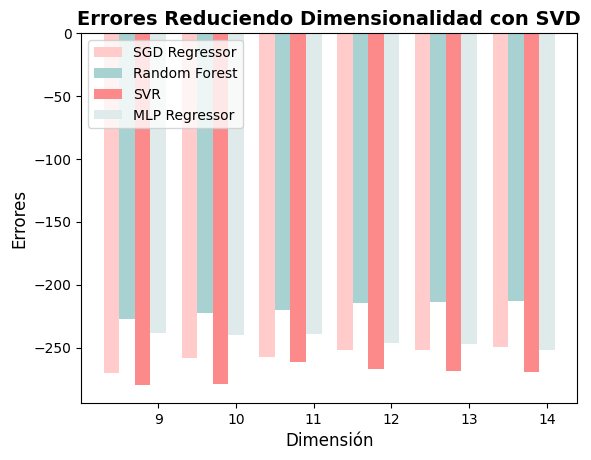

In [ ]:
x = np.array(n_features)

plt.figure()

plt.bar(x - 0.6, errors_svd['SGD'], color=colors[0], width=0.2, label='SGD Regressor', align='center')
plt.bar(x - 0.4, errors_svd['RF'], color=colors[1], width=0.2, label='Random Forest', align='center')
plt.bar(x - 0.2, errors_svd['SVR'], color=colors[2], width=0.2, label='SVR', align='center')
plt.bar(x, errors_svd['MLP'], color=colors[3], width=0.2, label='MLP Regressor', align='center')

plt.title("Errores Reduciendo Dimensionalidad con SVD", fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel("Dimensión", fontdict={'fontsize': 12})
plt.ylabel("Errores", fontdict={'fontsize': 12})
plt.legend(loc='upper left')
plt.xticks(x)
plt.axis("tight")

plt.show()

## **3. FEATURE SELECTION**

### **3.1 FEATURE IMPORTANCE CON LASSO**

First of all, we will perform an analysis to get an idea of the importance of the features and then we will apply different feature selection methods. We will use Lasso which penalizes some coefficients to zero, so the features associated with those coefficients will have less importance.

In [ ]:
from sklearn.linear_model import Lasso

hyper_params = {'alpha': [0.001, 0.01, 0.1, 1.0],
                'selection': ['cyclic', 'random']}

np.random.seed(42)

grid_lasso = GridSearchCV(Lasso(), hyper_params, cv=5)
grid_lasso.fit(X_train, y_train)

grid_lasso.best_params_

{'alpha': 0.001, 'selection': 'cyclic'}

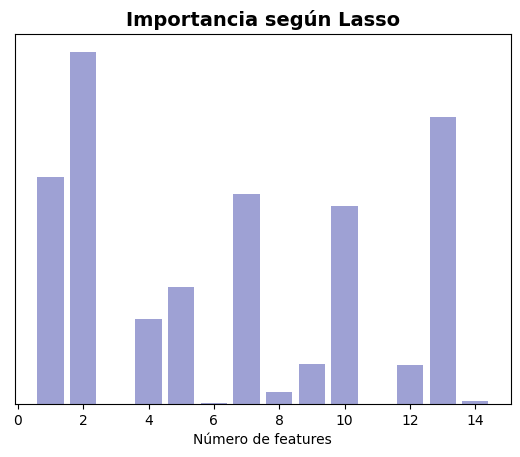

In [ ]:
lasso = Lasso(alpha=grid_lasso.best_params_['alpha'],
              selection=grid_lasso.best_params_['selection'])
lasso.fit(X_train, y_train)

feature_importances = np.abs(lasso.coef_)
x = n_features = [x for x in range(1, X_train.shape[1] + 1)]

plt.figure()
plt.bar(x, feature_importances, color='#9EA1D4')
plt.xlabel('Número de features')
plt.title('Importancia según Lasso', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.yticks(())
plt.axis("tight")
plt.show()

We see that of all the features, 7 are the most important.

### **3.2 FEATURE IMPORTANCE CON RFE**

With `RFE()` we eliminate the features recursively. We will use a Random Forest as estimator and then visualize a ranking of the features using a pixel map.

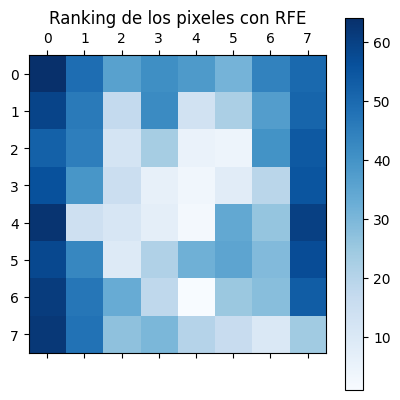

In [ ]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE

digits = load_digits()
X_rfe = digits.images.reshape((len(digits.images), -1))
y_rfe = digits.target

rfr = RandomForestRegressor()
rfe = RFE(estimator=rfr, n_features_to_select=1, step=1)
rfe.fit(X_rfe, y_rfe)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking de los pixeles con RFE")
plt.show()

### **3.3.1 SELECT FROM MODEL**

In [ ]:
from sklearn.feature_selection import SelectFromModel

errors_sfm = {'SGD': [], 'RF': [], 'SVR': [], 'MLP': []}
scores_sfm = {'SGD': [], 'RF': [], 'SVR': [], 'MLP': []}

ks = range(7, X_train.shape[-1]+1, 2)

for k in ks:
    np.random.seed(42)
    print(f'SELECT FROM MODEL CON K={k}')
    threshold = np.sort(feature_importances)[-k] + 0.01

    # SGD
    print('\nSGD REGRESSOR\n')
    sgd = make_pipeline(SelectFromModel(lasso, threshold=threshold),
                        StandardScaler(),
                        SGDRegressor(alpha=grid_sgd.best_params_['alpha'],
                                 penalty=grid_sgd.best_params_['penalty'],
                                 learning_rate=grid_sgd.best_params_['learning_rate'],
                                 random_state=0)
                        )
    sgd.fit(X_train, y_train)

    cv_score_1 = cross_val_score(sgd, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_1 = sgd.score(X_val, y_val)

    print(f'cv_score SGD: {cv_score_1.mean()}')
    print(f'R2 Error SGD: {r2_1 * 100} %')

    errors_sfm['SGD'].append(cv_score_1.mean())
    scores_sfm['SGD'].append(r2_1)

    # RANDOM FOREST
    print('\nRANDOM FOREST REGRESSOR\n')
    tree = make_pipeline(SelectFromModel(lasso, threshold=threshold),
                         StandardScaler(),
                         RandomForestRegressor(
                              n_estimators=tree_best_params['n_estimators'],
                              criterion=tree_best_params['criterion'],
                              n_jobs=-1,
                              random_state=0)
                          )
    tree.fit(X_train, y_train)

    cv_score_2 = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_2 = tree.score(X_val, y_val)

    print(f'cv_score RF: {cv_score_2.mean()}')
    print(f'R2 Error RF: {r2_2 * 100} %')

    errors_sfm['RF'].append(cv_score_2.mean())
    scores_sfm['RF'].append(r2_2)

    # SVR
    print('\nSVR\n')
    svr = make_pipeline(SelectFromModel(lasso, threshold=threshold),
                        StandardScaler(),
                        SVR(
                            kernel=svr_best_params['kernel'],
                            gamma=svr_best_params['gamma'],
                            C=svr_best_params['C'])
                        )
    svr.fit(X_train, y_train)
    y_pred_3 = svr.predict(X_val)

    cv_score_3 = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_3 = svr.score(X_val, y_val)

    print(f'cv_score SVR: {cv_score_3.mean()}')
    print(f'R2 Error SVR: {r2_3 * 100} %')

    errors_sfm['SVR'].append(cv_score_3.mean())
    scores_sfm['SVR'].append(r2_3)

    # MLP
    print('\nMLP REGRESSOR\n')
    mlp = make_pipeline(SelectFromModel(lasso, threshold=threshold),
                        StandardScaler(),
                        MLPRegressor(hidden_layer_sizes=100,
                                 solver=mlp_best_params['solver'],
                                 activation=mlp_best_params['activation'],
                                 learning_rate=mlp_best_params['learning_rate'],
                                 max_iter=3000,
                                 random_state=0)
                        )
    mlp.fit(X_train, y_train)

    cv_score_4 = cross_val_score(mlp, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_4 = mlp.score(X_val, y_val)

    print(f'cv_score MLP: {cv_score_4.mean()}')
    print(f'R2 Error MLP: {r2_4 * 100} %')

    errors_sfm['MLP'].append(cv_score_4.mean())
    scores_sfm['MLP'].append(r2_4)

    print('---------------------------------------------------------------------------\n')

SELECT FROM MODEL CON K=7

SGD REGRESSOR

cv_score SGD: -256.6884961352
R2 Error SGD: 19.491141835487003 %

RANDOM FOREST REGRESSOR

cv_score RF: -226.76252355950456
R2 Error RF: 28.954603878490236 %

SVR

cv_score SVR: -250.38225578129496
R2 Error SVR: 22.086609875432984 %

MLP REGRESSOR

cv_score MLP: -231.18530308099253
R2 Error MLP: 27.030442424850452 %
---------------------------------------------------------------------------

SELECT FROM MODEL CON K=9

SGD REGRESSOR

cv_score SGD: -255.90902875255216
R2 Error SGD: 19.689987928904394 %

RANDOM FOREST REGRESSOR

cv_score RF: -222.62167659148196
R2 Error RF: 31.797674660829113 %

SVR

cv_score SVR: -248.2830155364849
R2 Error SVR: 24.04504600675522 %

MLP REGRESSOR

cv_score MLP: -230.90687078153513
R2 Error MLP: 28.240840113677436 %
---------------------------------------------------------------------------

SELECT FROM MODEL CON K=11

SGD REGRESSOR

cv_score SGD: -251.7771779846562
R2 Error SGD: 20.769048295608005 %

RANDOM FORES

### **3.3.2 PLOTS**

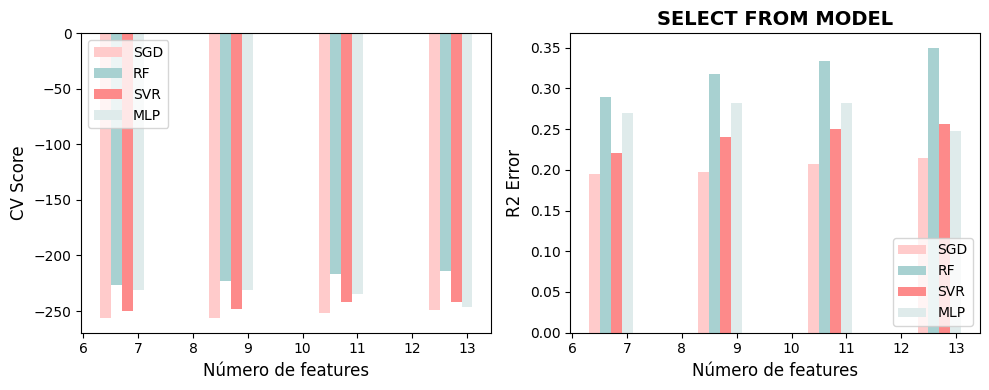

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
x = np.array(ks)

for model, color, offset in zip(errors_sfm.keys(), colors, [0.6, 0.4, 0.2, 0.00]):
    axs[0].bar(x - offset, errors_sfm[model], color=color, width=0.2, label=model, align='center')
axs[0].set_xlabel('Número de features', fontdict={'fontsize': 12})
axs[0].set_ylabel('CV Score', fontdict={'fontsize': 12})
axs[0].legend(loc='upper left')

for model, color, offset in zip(scores_sfm.keys(), colors, [0.6, 0.4, 0.2, 0.00]):
    axs[1].bar(x - offset, scores_sfm[model], color=color, width=0.2, label=model, align='center')
axs[1].set_xlabel('Número de features', fontdict={'fontsize': 12})
axs[1].set_ylabel('R2 Error', fontdict={'fontsize': 12})
axs[1].legend(loc='lower right')

plt.title('SELECT FROM MODEL', fontdict={'fontsize': 14, 'fontweight': 'bold'}, loc='center')
plt.tight_layout()
plt.show()

### **3.4.1 SELECT K BEST**

In [ ]:
from sklearn.feature_selection import SelectKBest

errors_kbest = {'SGD': [], 'RF': [], 'SVR': [], 'MLP': []}
scores_kbest = {'SGD': [], 'RF': [], 'SVR': [], 'MLP': []}

nfs = range(7, X_train.shape[-1]+1, 2)

for n in nfs:
    np.random.seed(42)
    print(f'SELECT K BEST CON K={n}')

    # SGD
    print('\nSGD REGRESSOR\n')
    sgd = make_pipeline(SelectKBest(k=n),
                        StandardScaler(),
                        SGDRegressor(alpha=grid_sgd.best_params_['alpha'],
                                 penalty=grid_sgd.best_params_['penalty'],
                                 learning_rate=grid_sgd.best_params_['learning_rate'],
                                 random_state=0)
                        )
    sgd.fit(X_train, y_train)

    cv_score_1 = cross_val_score(sgd, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_1 = sgd.score(X_val, y_val)

    print(f'cv_score SGD: {cv_score_1.mean()}')
    print(f'R2 Error SGD: {r2_1 * 100} %')

    errors_kbest['SGD'].append(cv_score_1.mean())
    scores_kbest['SGD'].append(r2_1)

    # RANDOM FOREST
    print('\nRANDOM FOREST REGRESSOR\n')
    tree = make_pipeline(SelectKBest(k=n),
                         StandardScaler(),
                         RandomForestRegressor(
                              n_estimators=tree_best_params['n_estimators'],
                              criterion=tree_best_params['criterion'],
                              n_jobs=-1,
                              random_state=0)
                          )
    tree.fit(X_train, y_train)

    cv_score_2 = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_2 = tree.score(X_val, y_val)

    print(f'cv_score RF: {cv_score_2.mean()}')
    print(f'R2 Error RF: {r2_2 * 100} %')

    errors_kbest['RF'].append(cv_score_2.mean())
    scores_kbest['RF'].append(r2_2)

    # SVR
    print('\nSVR\n')
    svr = make_pipeline(SelectKBest(k=n),
                        StandardScaler(),
                        SVR(
                            kernel=svr_best_params['kernel'],
                            gamma=svr_best_params['gamma'],
                            C=svr_best_params['C'])
                        )
    svr.fit(X_train, y_train)
    y_pred_3 = svr.predict(X_val)

    cv_score_3 = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_3 = svr.score(X_val, y_val)

    print(f'cv_score SVR: {cv_score_3.mean()}')
    print(f'R2 Error SVR: {r2_3 * 100} %')

    errors_kbest['SVR'].append(cv_score_3.mean())
    scores_kbest['SVR'].append(r2_3)

    # MLP
    print('\nMLP REGRESSOR\n')
    mlp = make_pipeline(SelectKBest(k=n),
                        StandardScaler(),
                        MLPRegressor(hidden_layer_sizes=100,
                                 solver=mlp_best_params['solver'],
                                 activation=mlp_best_params['activation'],
                                 learning_rate=mlp_best_params['learning_rate'],
                                 max_iter=3000,
                                 random_state=0)
                        )
    mlp.fit(X_train, y_train)

    cv_score_4 = cross_val_score(mlp, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_4 = mlp.score(X_val, y_val)

    print(f'cv_score MLP: {cv_score_4.mean()}')
    print(f'R2 Error MLP: {r2_4 * 100} %')

    errors_kbest['MLP'].append(cv_score_4.mean())
    scores_kbest['MLP'].append(r2_4)

    print('---------------------------------------------------------------------------\n')

SELECT K BEST CON K=7

SGD REGRESSOR

cv_score SGD: -260.2542446578144
R2 Error SGD: 18.791167160052503 %

RANDOM FOREST REGRESSOR

cv_score RF: -226.79426385994924
R2 Error RF: 31.563928236085903 %

SVR

cv_score SVR: -256.14491623169016
R2 Error SVR: 20.903851970787844 %

MLP REGRESSOR

cv_score MLP: -233.19348114706207
R2 Error MLP: 28.013224056816032 %
---------------------------------------------------------------------------

SELECT K BEST CON K=9

SGD REGRESSOR

cv_score SGD: -257.21784853817087
R2 Error SGD: 19.2416590585052 %

RANDOM FOREST REGRESSOR

cv_score RF: -223.45735261412227
R2 Error RF: 32.212194786265805 %

SVR

cv_score SVR: -255.26398351696224
R2 Error SVR: 20.92676477008759 %

MLP REGRESSOR

cv_score MLP: -237.53906056658087
R2 Error MLP: 27.055876507072117 %
---------------------------------------------------------------------------

SELECT K BEST CON K=11

SGD REGRESSOR

cv_score SGD: -249.49080404386896
R2 Error SGD: 21.50140528243942 %

RANDOM FOREST REGRESSO

### **3.4.2 PLOTS**

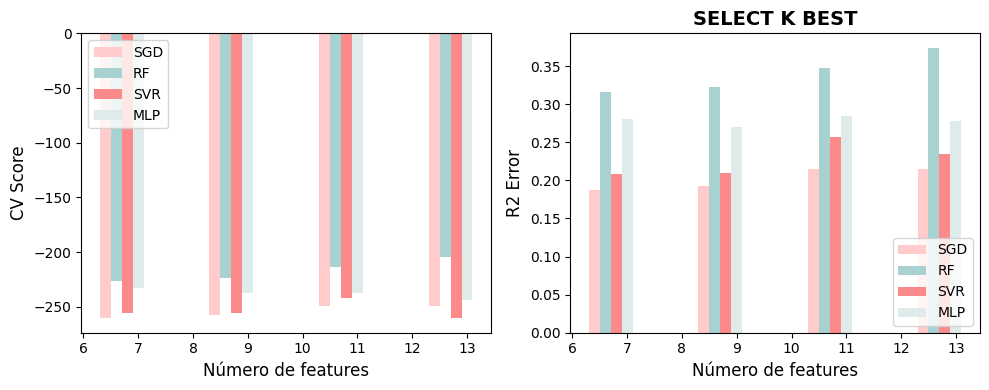

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
x = np.array(nfs)

for model, color, offset in zip(errors_kbest.keys(), colors, [0.6, 0.4, 0.2, 0.00]):
    axs[0].bar(x - offset, errors_kbest[model], color=color, width=0.2, label=model, align='center')
axs[0].set_xlabel('Número de features', fontdict={'fontsize': 12})
axs[0].set_ylabel('CV Score', fontdict={'fontsize': 12})
axs[0].legend(loc='upper left')

for model, color, offset in zip(scores_kbest.keys(), colors, [0.6, 0.4, 0.2, 0.00]):
    axs[1].bar(x - offset, scores_kbest[model], color=color, width=0.2, label=model, align='center')
axs[1].set_xlabel('Número de features', fontdict={'fontsize': 12})
axs[1].set_ylabel('R2 Error', fontdict={'fontsize': 12})
axs[1].legend(loc='lower right')

plt.title('SELECT K BEST', fontdict={'fontsize': 14, 'fontweight': 'bold'}, loc='center')
plt.tight_layout()
plt.show()

### **3.5.1 SEQUENTIAL FEATURE SELECTION**

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

errors_sfs = {'SGD': [], 'RF': [], 'SVR': [], 'MLP': []}
scores_sfs = {'SGD': [], 'RF': [], 'SVR': [], 'MLP': []}

nfs = range(7, X_train.shape[-1]+1, 2)

for n in nfs:
    np.random.seed(42)
    print(f'SEQUENTIAL FEATURE SELECTION  CON K={n}')

    # SGD
    print('\nSGD REGRESSOR\n')
    sgd = make_pipeline(SequentialFeatureSelector(lasso, n_features_to_select=n, direction='forward'),
                        StandardScaler(),
                        SGDRegressor(alpha=grid_sgd.best_params_['alpha'],
                                 penalty=grid_sgd.best_params_['penalty'],
                                 learning_rate=grid_sgd.best_params_['learning_rate'],
                                 random_state=0)
                        )
    sgd.fit(X_train, y_train)

    cv_score_1 = cross_val_score(sgd, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_1 = sgd.score(X_val, y_val)

    print(f'cv_score SGD: {cv_score_1.mean()}')
    print(f'R2 Error SGD: {r2_1 * 100} %')

    errors_sfs['SGD'].append(cv_score_1.mean())
    scores_sfs['SGD'].append(r2_1)

    # RANDOM FOREST
    print('\nRANDOM FOREST REGRESSOR\n')
    tree = make_pipeline(SequentialFeatureSelector(lasso, n_features_to_select=n, direction='forward'),
                         StandardScaler(),
                         RandomForestRegressor(
                              n_estimators=tree_best_params['n_estimators'],
                              criterion=tree_best_params['criterion'],
                              n_jobs=-1,
                              random_state=0)
                          )
    tree.fit(X_train, y_train)

    cv_score_2 = cross_val_score(tree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_2 = tree.score(X_val, y_val)

    print(f'cv_score RF: {cv_score_2.mean()}')
    print(f'R2 Error RF: {r2_2 * 100} %')

    errors_sfs['RF'].append(cv_score_2.mean())
    scores_sfs['RF'].append(r2_2)

    # SVR
    print('\nSVR\n')
    svr = make_pipeline(SequentialFeatureSelector(lasso, n_features_to_select=n, direction='forward'),
                        StandardScaler(),
                        SVR(
                            kernel=svr_best_params['kernel'],
                            gamma=svr_best_params['gamma'],
                            C=svr_best_params['C'])
                        )
    svr.fit(X_train, y_train)
    y_pred_3 = svr.predict(X_val)

    cv_score_3 = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_3 = svr.score(X_val, y_val)

    print(f'cv_score SVR: {cv_score_3.mean()}')
    print(f'R2 Error SVR: {r2_3 * 100} %')

    errors_sfs['SVR'].append(cv_score_3.mean())
    scores_sfs['SVR'].append(r2_3)

    # MLP
    print('\nMLP REGRESSOR\n')
    mlp = make_pipeline(SequentialFeatureSelector(lasso, n_features_to_select=n, direction='forward'),
                        StandardScaler(),
                        MLPRegressor(hidden_layer_sizes=100,
                                 solver=mlp_best_params['solver'],
                                 activation=mlp_best_params['activation'],
                                 learning_rate=mlp_best_params['learning_rate'],
                                 max_iter=3000,
                                 random_state=0)
                        )
    mlp.fit(X_train, y_train)

    cv_score_4 = cross_val_score(mlp, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_4 = mlp.score(X_val, y_val)

    print(f'cv_score MLP: {cv_score_4.mean()}')
    print(f'R2 Error MLP: {r2_4 * 100} %')

    errors_sfs['MLP'].append(cv_score_4.mean())
    scores_sfs['MLP'].append(r2_4)

    print('---------------------------------------------------------------------------\n')

SEQUENTIAL FEATURE SELECTION  CON K=7

SGD REGRESSOR

cv_score SGD: -252.79310122293919
R2 Error SGD: 21.24869262600032 %

RANDOM FOREST REGRESSOR

cv_score RF: -226.52822591787535
R2 Error RF: 31.502037939984728 %

SVR

cv_score SVR: -254.17568310584437
R2 Error SVR: 21.969774032891298 %

MLP REGRESSOR

cv_score MLP: -232.61657613921935
R2 Error MLP: 28.61097217110613 %
---------------------------------------------------------------------------

SEQUENTIAL FEATURE SELECTION  CON K=9

SGD REGRESSOR

cv_score SGD: -250.02421450150777
R2 Error SGD: 21.54240292325653 %

RANDOM FOREST REGRESSOR

cv_score RF: -216.57400097120413
R2 Error RF: 33.388777470385214 %

SVR

cv_score SVR: -242.95098432942154
R2 Error SVR: 25.24320574967853 %

MLP REGRESSOR

cv_score MLP: -230.00354066148094
R2 Error MLP: 28.563932793617564 %
---------------------------------------------------------------------------

SEQUENTIAL FEATURE SELECTION  CON K=11

SGD REGRESSOR

cv_score SGD: -249.12448641066598
R2 Error 

### **3.5.2 PLOTS**

In [ ]:
errors_sfs

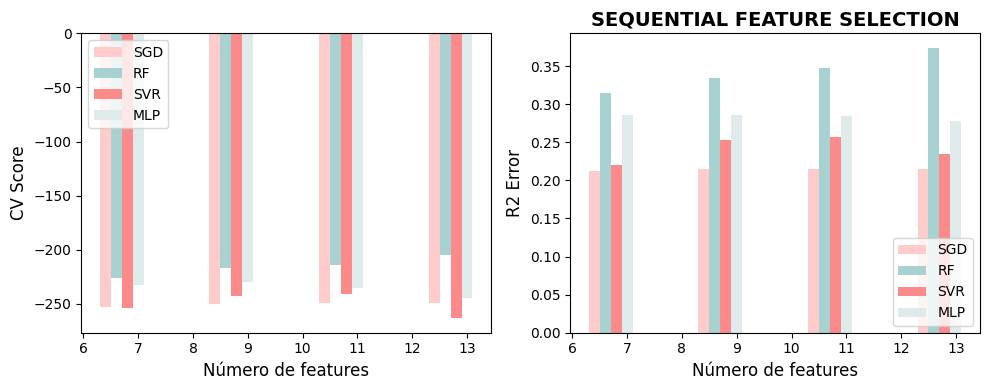

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
x = np.array(nfs)

for model, color, offset in zip(errors_sfs.keys(), colors, [0.6, 0.4, 0.2, 0.00]):
    axs[0].bar(x - offset, errors_sfs[model], color=color, width=0.2, label=model, align='center')
axs[0].set_xlabel('Número de features', fontdict={'fontsize': 12})
axs[0].set_ylabel('CV Score', fontdict={'fontsize': 12})
axs[0].legend(loc='upper left')

for model, color, offset in zip(scores_sfs.keys(), colors, [0.6, 0.4, 0.2, 0.00]):
    axs[1].bar(x - offset, scores_sfs[model], color=color, width=0.2, label=model, align='center')
axs[1].set_xlabel('Número de features', fontdict={'fontsize': 12})
axs[1].set_ylabel('R2 Error', fontdict={'fontsize': 12})
axs[1].legend(loc='lower right')

plt.title('SEQUENTIAL FEATURE SELECTION', fontdict={'fontsize': 14, 'fontweight': 'bold'}, loc='center')
plt.tight_layout()
plt.show()